In [1]:
import pandas as pd
import numpy as np
import os
import json
import pandas_datareader.data as web   # my local kernel Python 3.10.7 
import matplotlib.pyplot as plt  # unavailable?  do: 1. pip uninstall matplotlib # 2. python3 -m pip install matplotlib
%matplotlib inline
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import datetime
import io
pd.set_option('display.max_columns', None)
# import warnings
import seaborn as sns
import scipy
from scipy import stats
# warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import talib as ta
import scipy
from scipy import stats
import mplfinance as mpf
# from library.sb_utils import save_file
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.set_option('display.max_rows', 100)  # Display up to 100 rows
pd.set_option('display.max_columns', 50)  # Display up to 50 columns
pd.set_option('display.max_colwidth',100)  # Display up to 100 characters per column value

# !pip install plotly
import plotly

In [5]:
directory_path =  r"C:\Repo\D_47"
dfs = []
for file in os.listdir(directory_path):
    if file.endswith('.pickle'):
        df = pd.read_pickle(os.path.join(directory_path, file))
        dfs.append(df)
down_df = pd.concat(dfs, axis= 0)
# down_df.shape  #(16836, 8)

# NQ Down

## Features Engineering

In [ ]:
nqDown= down_df[down_df['close'] > 6000]

# Calculate OnBalanceVolume indicator and OnBalanceBidAsk indicator
OBV = []
OBV.append(0)
for i in range(1, len(nqDown.close)):
    if nqDown.close[i] > nqDown.close[i-1]: # If the closing price is above the prior close price 
          OBV.append(OBV[-1] + nqDown.Vol[i]) # then: Current OBV = Previous OBV + Current Volume
    elif nqDown.close[i] < nqDown.close[i-1]:
          OBV.append( OBV[-1] - nqDown.Vol[i])
    else:
          OBV.append(OBV[-1])
          
obBA = []
obBA.append(0)
for i in range(1, len(nqDown.close)):
    if nqDown.close[i] > nqDown.close[i-1]: # If the closing price is above the prior close price 
          obBA.append(obBA[-1] + nqDown.BidAsk[i]) # then: Current OBV = Previous OBV + Current Volume
    elif nqDown.close[i] < nqDown.close[i-1]:
          obBA.append( obBA[-1] - nqDown.BidAsk[i])
    else:
          obBA.append(obBA[-1])

nqDown['vari'] = nqDown.close - nqDown.open
nqDown['volat'] = nqDown.high - nqDown.low
nqDown['taly'] = nqDown.Vol - nqDown.BidAsk

nqDown['diff'] = (nqDown.close.diff()).fillna(method='bfill') 
nqDown['pct_chng'] = nqDown.close.pct_change().fillna(method='bfill') * 100  
nqDown['fut_10'] = (nqDown.close.shift(-10) - nqDown.close).fillna(method='ffill')
nqDown['fut_5'] = (nqDown.close.shift(-5) - nqDown.close).fillna(method='ffill')
nqDown["volatility"] = (nqDown["pct_chng"].rolling(window= 2).std() * 100).fillna(method='bfill')    
nqDown['BA_2m'] = (nqDown['BidAsk'].rolling(2).mean()).fillna(method='bfill')  
nqDown['BA_5m'] = (nqDown['BidAsk'].rolling(5).mean()).fillna(method='bfill')  
nqDown['BA_10m'] = (nqDown['BidAsk'].rolling(10).mean()).fillna(method='bfill')  

nqDown['BA_cs'] = nqDown.BidAsk.cumsum()
nqDown['BAr_V'] = (nqDown.BidAsk.rolling(3).sum() - nqDown.Vol).fillna(method='bfill')


nqDown['vwap'] = (nqDown.Vol * (nqDown.high + nqDown.low) / 2).cumsum() / nqDown.Vol.cumsum() 
nqDown['vwapBA'] = ((nqDown.Vol * (nqDown.high + nqDown.low) / 2).cumsum() / nqDown.Vol.cumsum() ) / nqDown['taly']
nqDown['typeD'] = -0.5

nqDown['OBV'] = OBV
nqDown['obBA'] = obBA

nqDown= nqDown.replace([np.inf, -np.inf], np.finfo(np.float64).max)
mask = nqDown.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
print(f'Total number of infinite values: {inf_count}') # Total number of infinite values: 0 
nqDown.replace([np.inf, -np.inf], np.nan, inplace=True)
nqDown= nqDown.replace([np.inf, -np.inf], np.finfo(np.float64).min)

print(nqDown.shape)   # (8052, 26)
nqDown.head()
# nqDown.tail()
# nqDown.head()
# nqDown.sample()
esdays = nqDown.groupby(nqDown.index.to_period('D')).ngroups # 22
print('NQ days are ', esdays)  #  NQ days are  22


### Normalize 

In [15]:
idx_date = nqDown.index
print(len(idx_date) )  #  8052
# nqDown.index = pd.to_datetime(nqDown.index) # make sure its Datetime index

# Group by day
daily_group = nqDown.groupby(nqDown.index.date)

# # Define the mean normalization scaling function
def mean_normalization(group):
    mean_value = group.mean()
    min_value = group.min()
    max_value = group.max()
    return (group - mean_value) / (max_value - min_value)

# Apply the mean normalization scaling function to each day's 'Close' values
nq_centered = daily_group.transform(mean_normalization)

# Display the resulting centered Series
# print(nq_centered)
print('index is ', type(nq_centered.index))
nq_centered = nq_centered.sort_index()
nq_centered['typeD'] = -.5


8052
index is  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [17]:
nan_columns = nq_centered.isna().any()
# Count the number of NaN values per column
nan_count = nan_columns.isna().sum()
# Total number of NaN values in the entire DataFrame
total_nan_count = nan_count.sum()
print("\nTotal number of NaN values in the DataFrame:", total_nan_count)

# Deal w Inf values
mask = nq_centered.isin([np.inf, -np.inf])
inf_count = mask.values.sum()
# print the mask and the number of infinite values
# print(mask)
print(f'Total number of infinite values: {inf_count}') #    1830
nq_centered = nq_centered.replace([np.inf, -np.inf], np.finfo(np.float64).max)
print(f'Total number of infinite values: {inf_count}') #    0



Total number of NaN values in the DataFrame: 0
Total number of infinite values: 0
Total number of infinite values: 0


In [18]:
unique_dates = np.unique(nq_centered.index.date)
print(len(unique_dates))  # 22
unique_dates

22


array([datetime.date(2022, 9, 27), datetime.date(2022, 9, 29),
       datetime.date(2022, 10, 7), datetime.date(2022, 10, 10),
       datetime.date(2022, 10, 14), datetime.date(2022, 10, 27),
       datetime.date(2022, 11, 1), datetime.date(2022, 11, 9),
       datetime.date(2022, 11, 18), datetime.date(2022, 11, 21),
       datetime.date(2022, 11, 28), datetime.date(2022, 12, 5),
       datetime.date(2022, 12, 6), datetime.date(2022, 12, 27),
       datetime.date(2022, 12, 28), datetime.date(2023, 1, 3),
       datetime.date(2023, 1, 18), datetime.date(2023, 2, 8),
       datetime.date(2023, 2, 9), datetime.date(2023, 2, 21),
       datetime.date(2023, 3, 7), datetime.date(2023, 3, 27)],
      dtype=object)

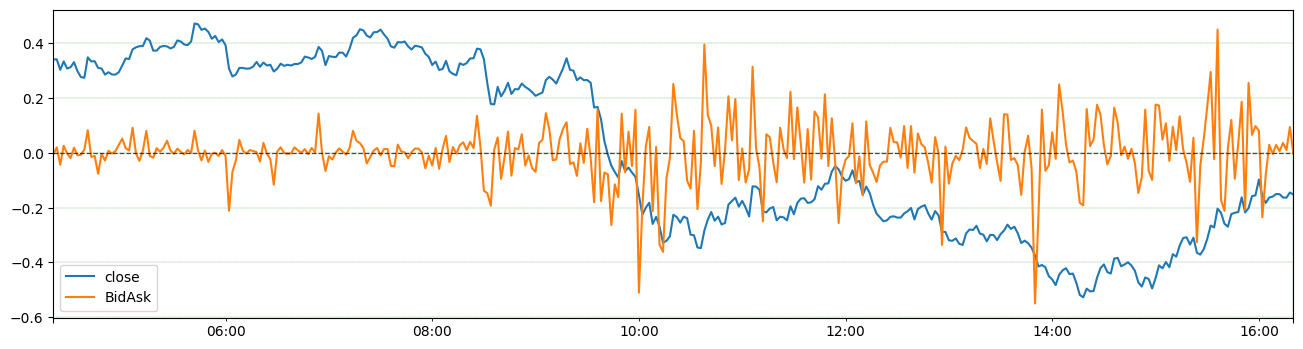

In [20]:
nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['close', 'BidAsk'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

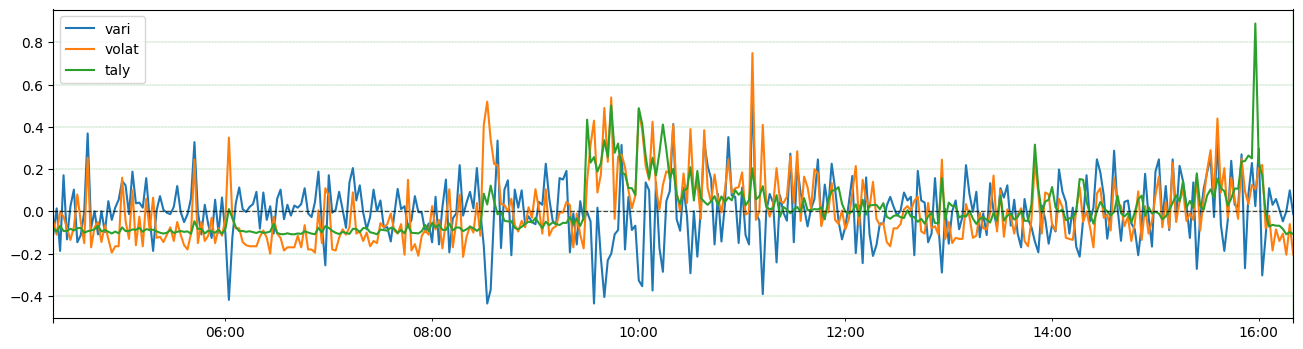

In [21]:
nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['vari', 'volat', 'taly'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

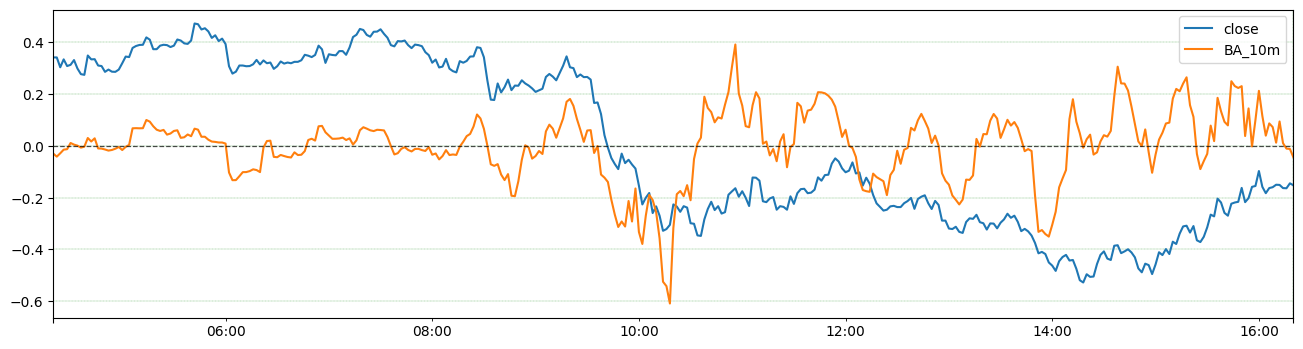

In [22]:

nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['close','BA_10m'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

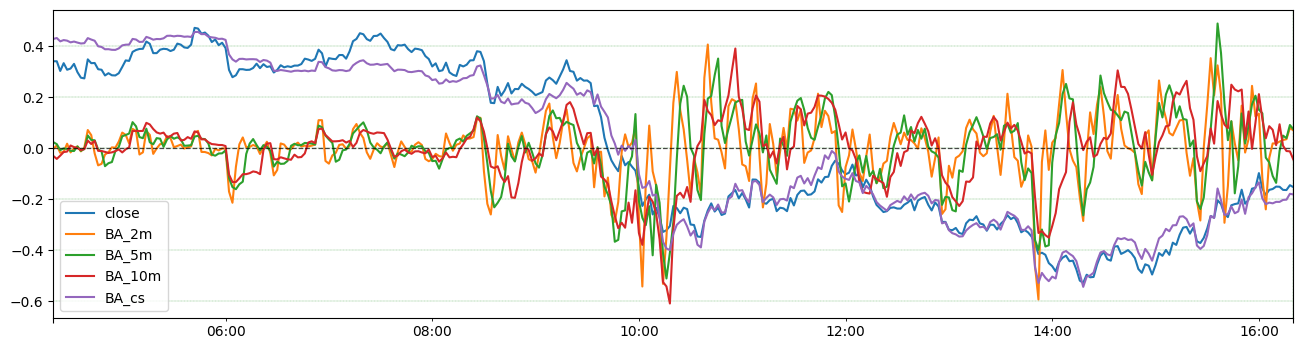

In [23]:
nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['close','BA_2m','BA_5m','BA_10m', 'BA_cs'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

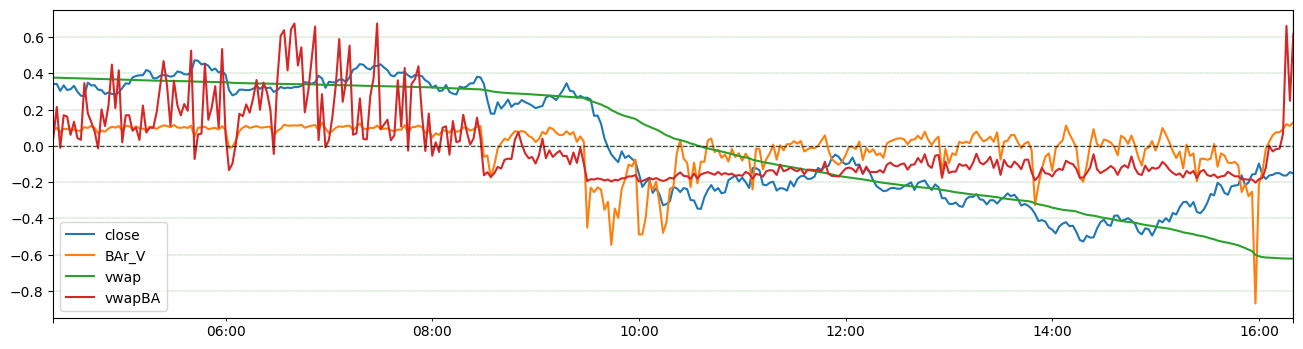

In [25]:
nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['close','BAr_V','vwap', 'vwapBA'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

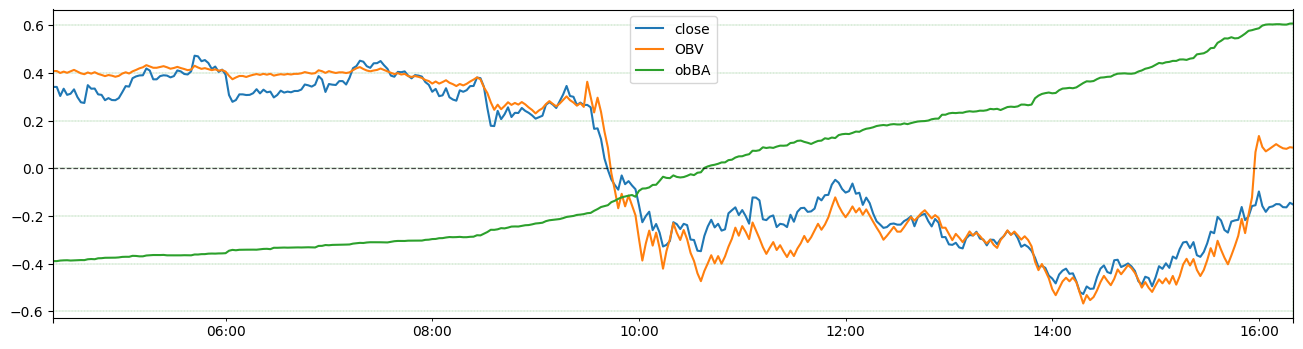

In [26]:
nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['close','OBV', 'obBA'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

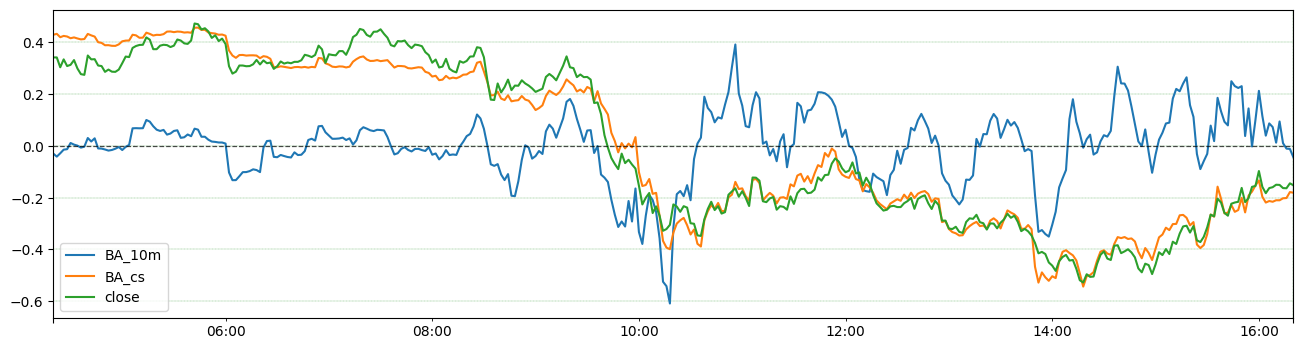

In [28]:

nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['BA_10m', 'BA_cs', 'close'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

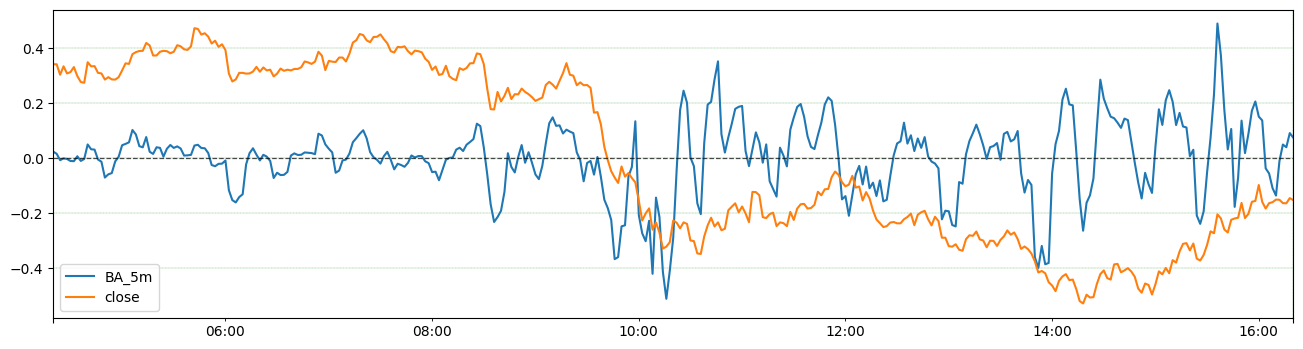

In [30]:
nq_centered['2022-9-29 04:20:00':'2022-9-29 16:20:00'].plot(y=['BA_5m', 'close'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

### SVD

Singular values for the 9-10 hour: [1.85950749e+01 1.24253237e+01 6.73996778e+00 6.32255280e+00
 5.15436255e+00 4.92168822e+00 3.66004464e+00 3.43731703e+00
 3.08022039e+00 2.67392544e+00 2.56173868e+00 2.31444862e+00
 2.20307292e+00 2.13807654e+00 1.84359744e+00 1.71927606e+00
 1.11174980e+00 5.21920264e-01 3.27327316e-01 2.90536398e-01
 2.54915645e-01 2.40853853e-01 1.50959497e-02]
Singular values for the 10-11 hour: [13.29052025 11.18307264  8.02288475  6.07896053  4.52488831  3.96234748
  3.70295199  3.26391323  3.04980623  2.80708481  2.622885    2.39267839
  2.22961917  1.81252449  1.72160367  1.57341417  1.28108729  0.64569561
  0.32891928  0.30031565  0.26875925  0.21937839  0.01509052]


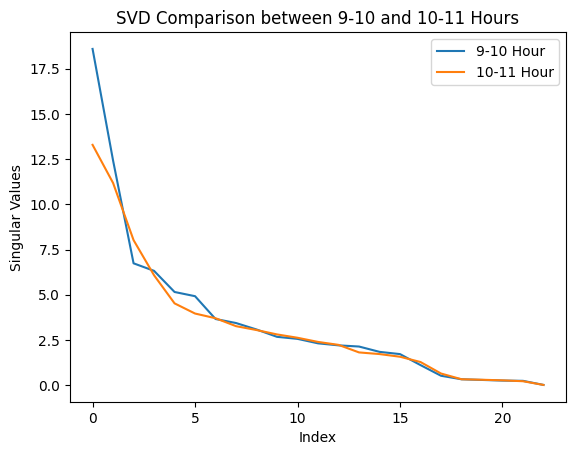

In [50]:
from scipy.linalg import svd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has columns 'Date' and 'Close'
# Make sure the 'Date' column is set as the index and is a datetime object
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = nq_centered.between_time('9:00', '10:00')
df_10_to_11 = nq_centered.between_time('10:00', '11:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_10_to_11, s_10_to_11, Vh_10_to_11 = svd(df_10_to_11)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_10_to_11)

# Plot the SVD values using matplotlib
plt.plot(s_9_to_10, label="9-10 Hour")
plt.plot(s_10_to_11, label="10-11 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 10-11 Hours")
plt.legend()
plt.show()


Singular values for the 9-10 hour: [1.85950749e+01 1.24253237e+01 6.73996778e+00 6.32255280e+00
 5.15436255e+00 4.92168822e+00 3.66004464e+00 3.43731703e+00
 3.08022039e+00 2.67392544e+00 2.56173868e+00 2.31444862e+00
 2.20307292e+00 2.13807654e+00 1.84359744e+00 1.71927606e+00
 1.11174980e+00 5.21920264e-01 3.27327316e-01 2.90536398e-01
 2.54915645e-01 2.40853853e-01 1.50959497e-02]
Singular values for the 10-11 hour: [2.51079522e+01 1.27933408e+01 7.18720131e+00 6.58940292e+00
 5.72409279e+00 4.66564561e+00 3.98700449e+00 3.48519215e+00
 2.81441588e+00 2.58998855e+00 2.54344486e+00 1.95022843e+00
 1.73657852e+00 1.54469071e+00 1.30707155e+00 1.24113672e+00
 9.30866339e-01 4.38715688e-01 2.89576829e-01 2.43874285e-01
 2.02266822e-01 1.80104376e-01 1.12954011e-02]


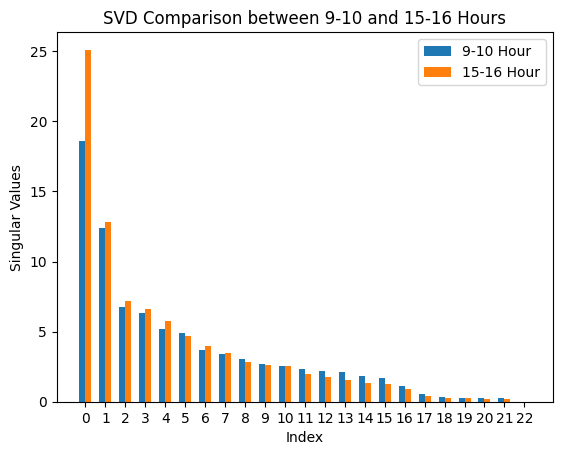

In [51]:

from scipy.linalg import svd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and has columns 'Date' and 'Close'
# Make sure the 'Date' column is set as the index and is a datetime object
# df['DateTime'] = pd.to_datetime(df['DateTime'])
# df.set_index('Date', inplace=True)

# Filter the DataFrame for the hours between 9-10 and 10-11
df_9_to_10 = nq_centered.between_time('9:00', '10:00')
df_15_to_16 = nq_centered.between_time('15:00', '16:00')

# Calculate the SVD values for both filtered DataFrames
U_9_to_10, s_9_to_10, Vh_9_to_10 = svd(df_9_to_10)
U_15_to_16, s_15_to_16, Vh_15_to_16 = svd(df_15_to_16)

# Compare the SVD values
print("Singular values for the 9-10 hour:", s_9_to_10)
print("Singular values for the 10-11 hour:", s_15_to_16)

# Plot the SVD values using matplotlib
bar_width = 0.3
index = np.arange(len(s_9_to_10))

plt.bar(index, s_9_to_10, width=bar_width, label="9-10 Hour")
plt.bar(index + bar_width, s_15_to_16, width=bar_width, label="15-16 Hour")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.title("SVD Comparison between 9-10 and 15-16 Hours")
plt.xticks(index + bar_width/2, index)
plt.legend()
plt.show()


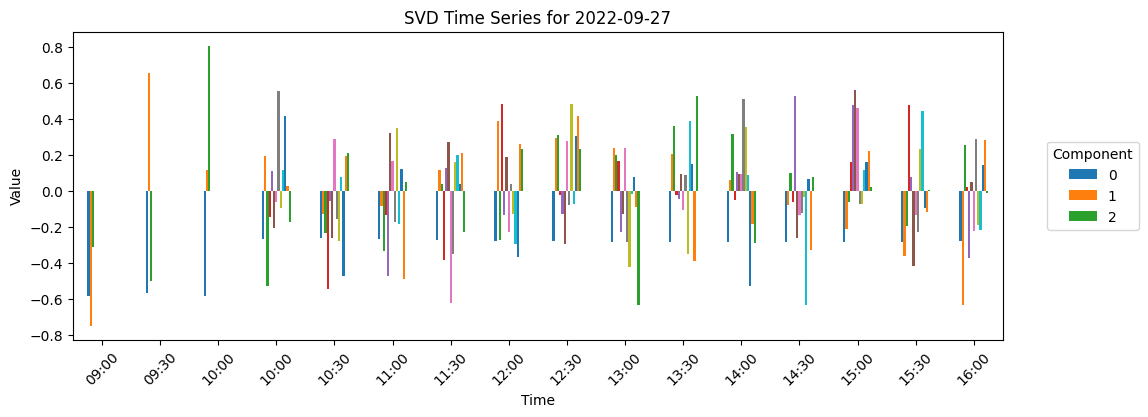

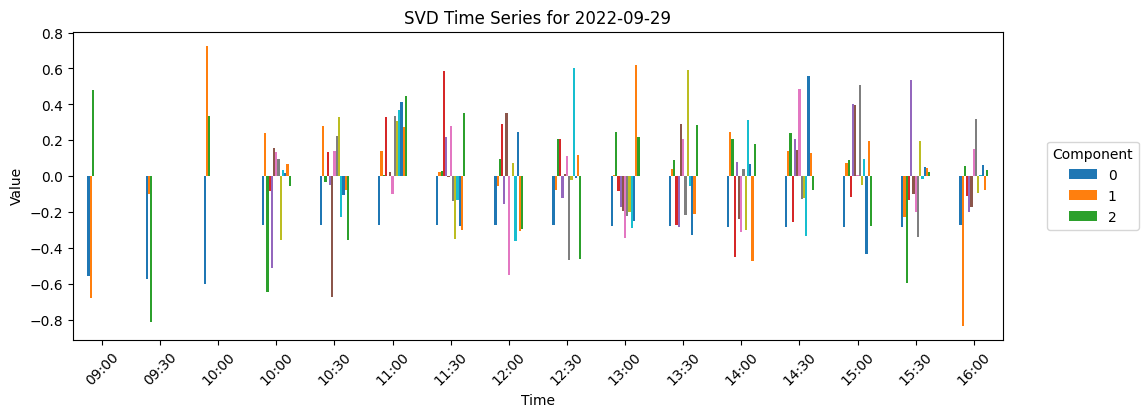

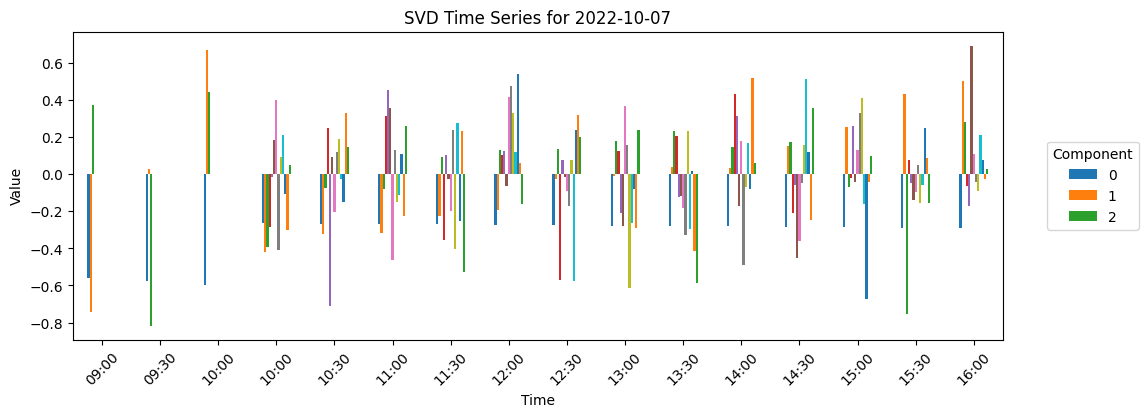

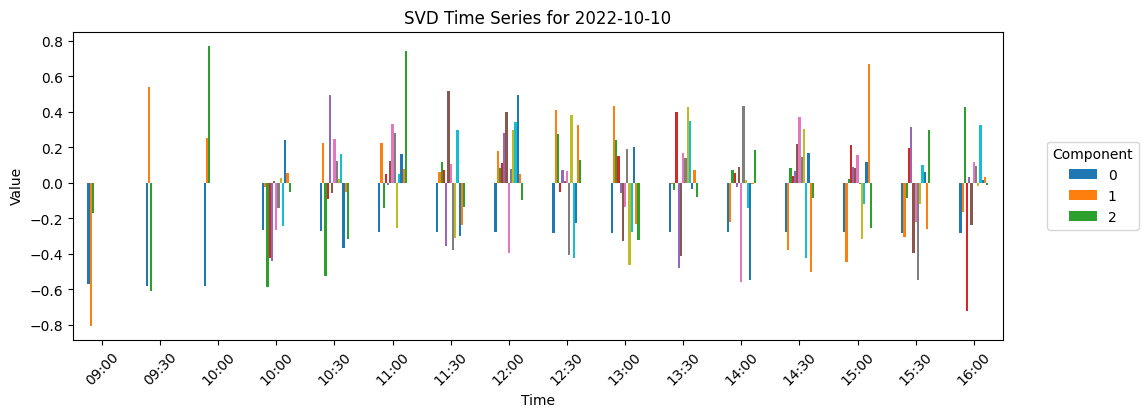

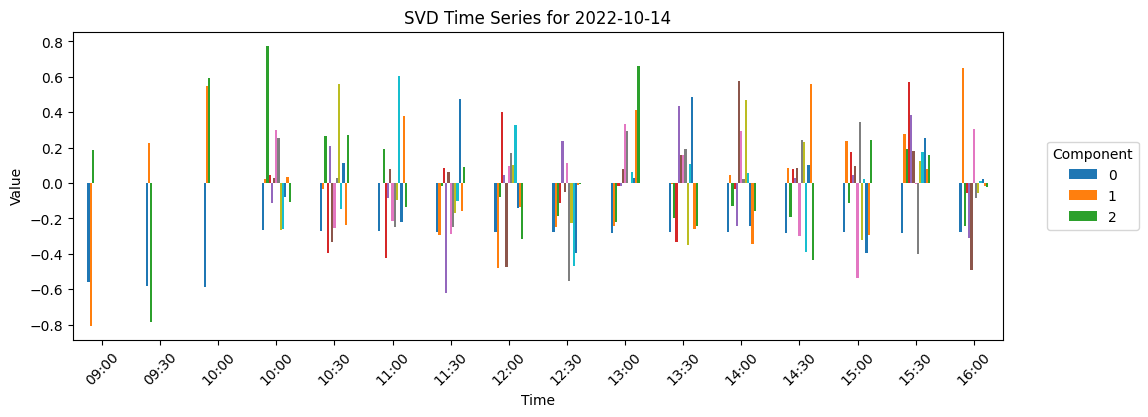

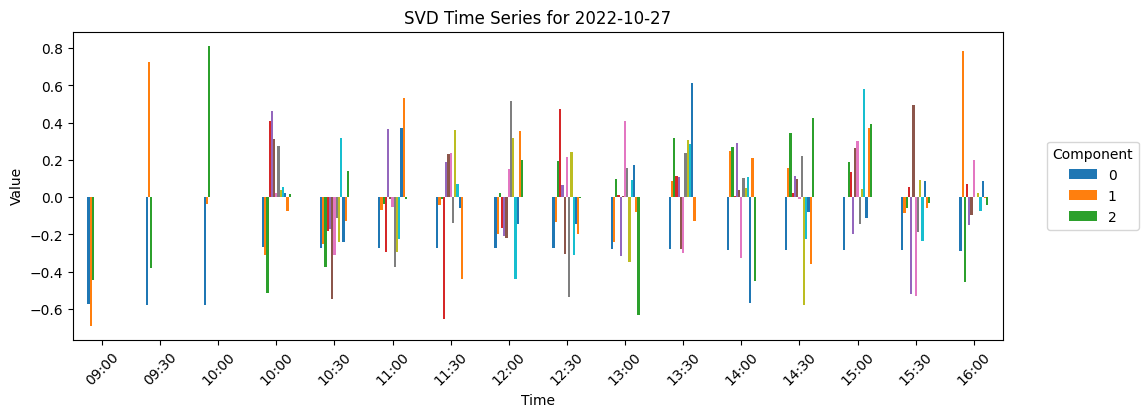

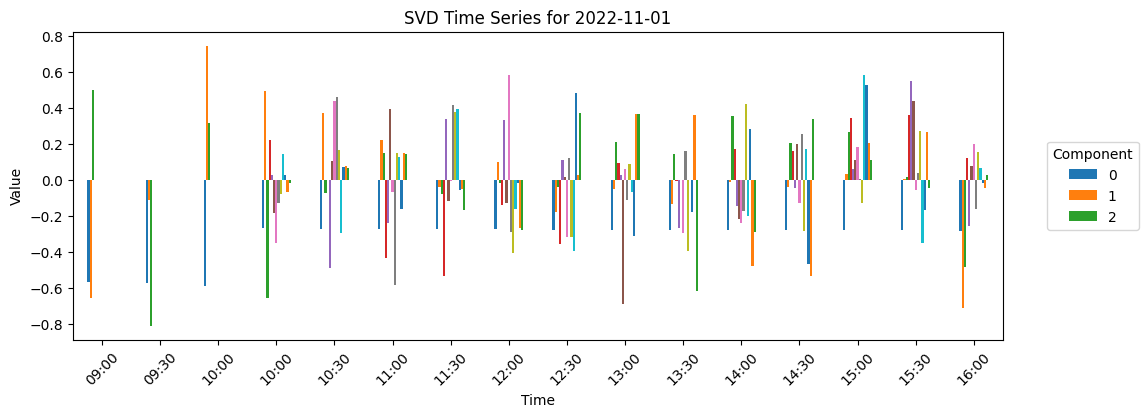

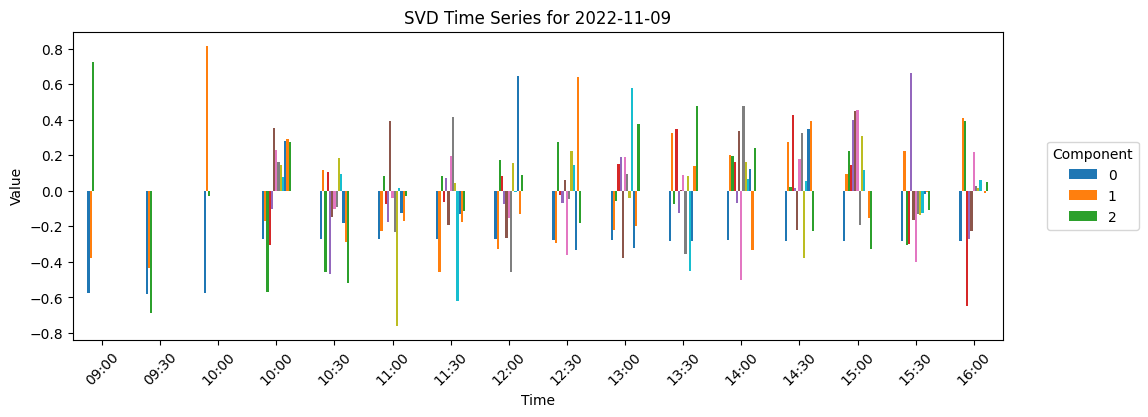

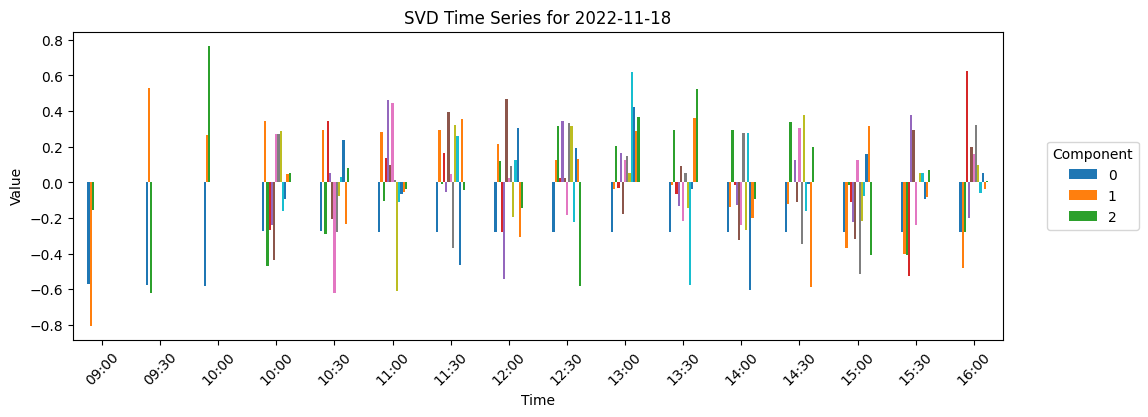

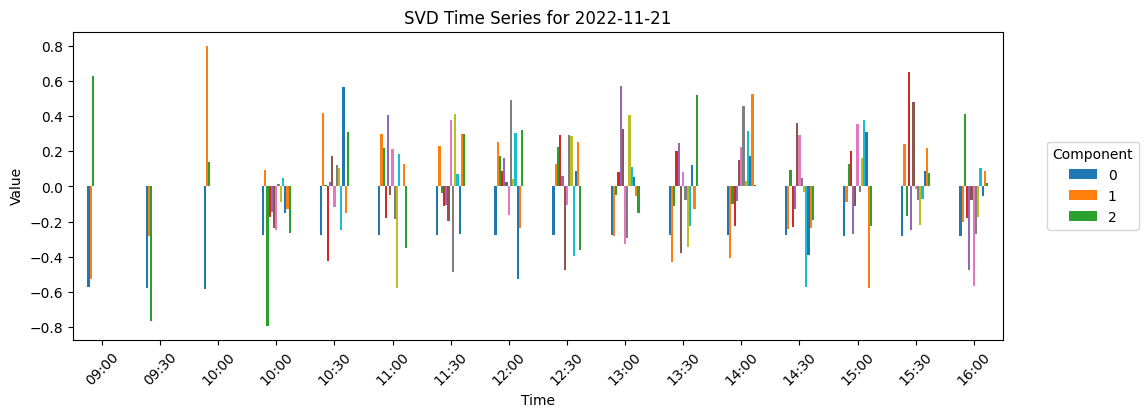

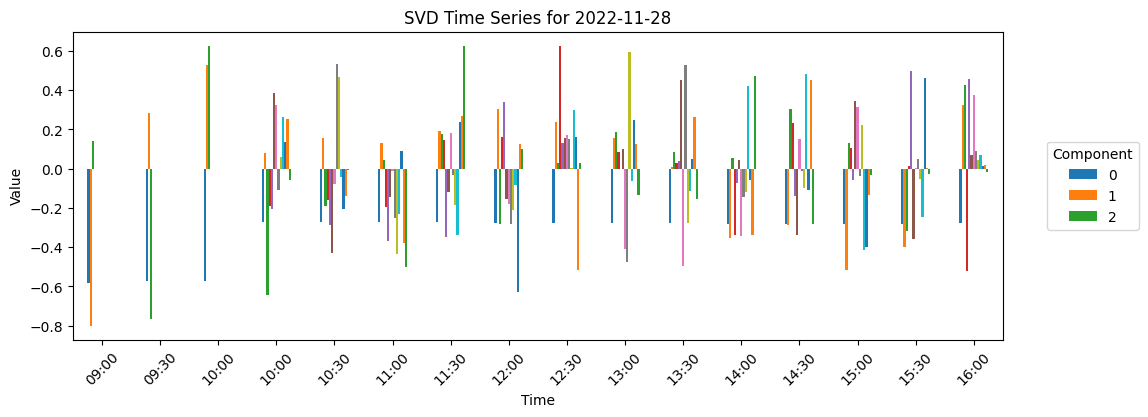

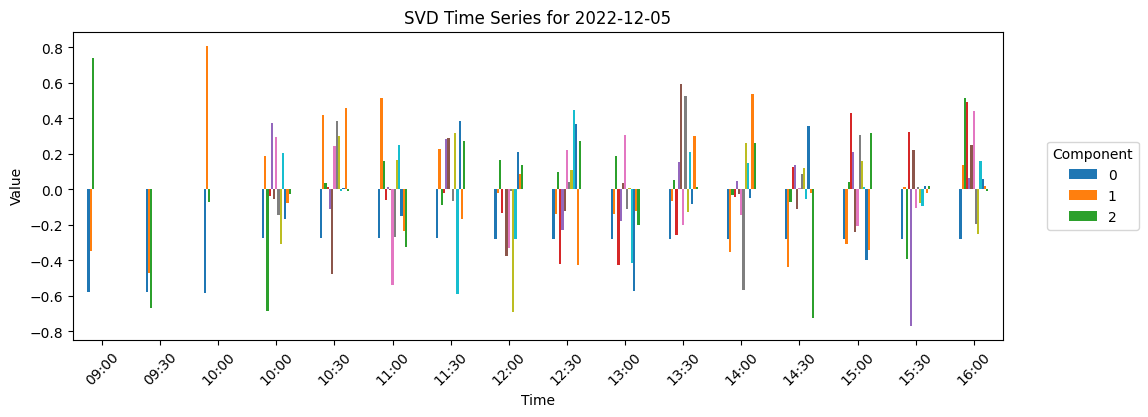

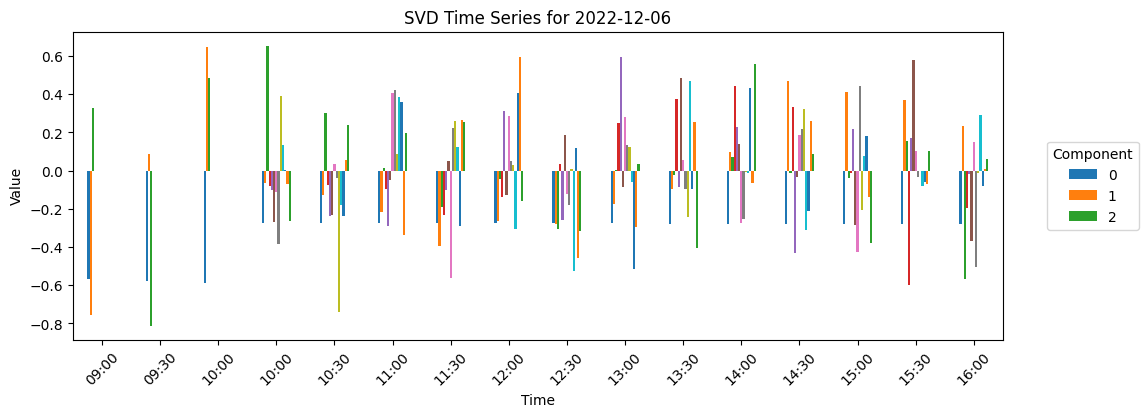

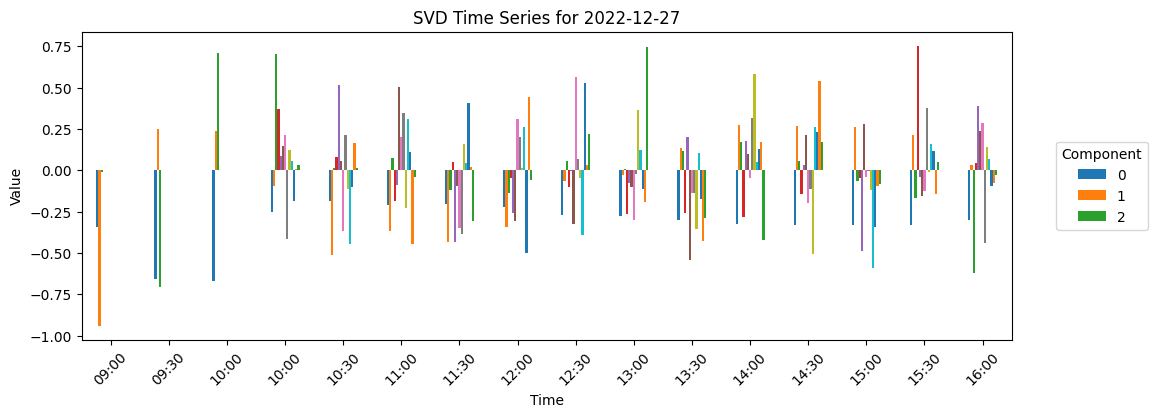

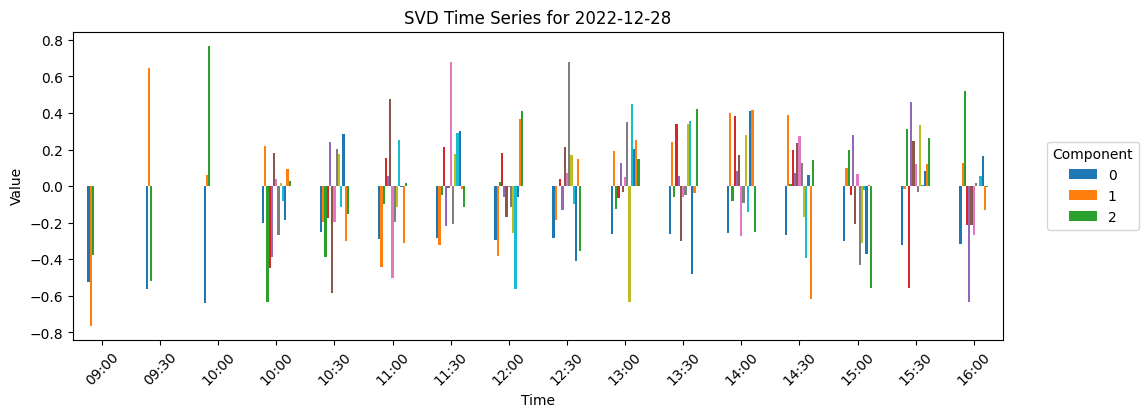

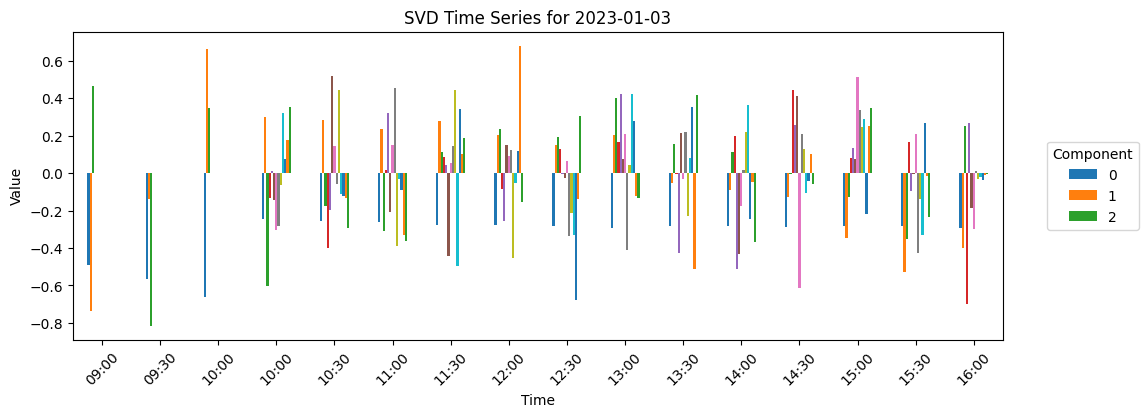

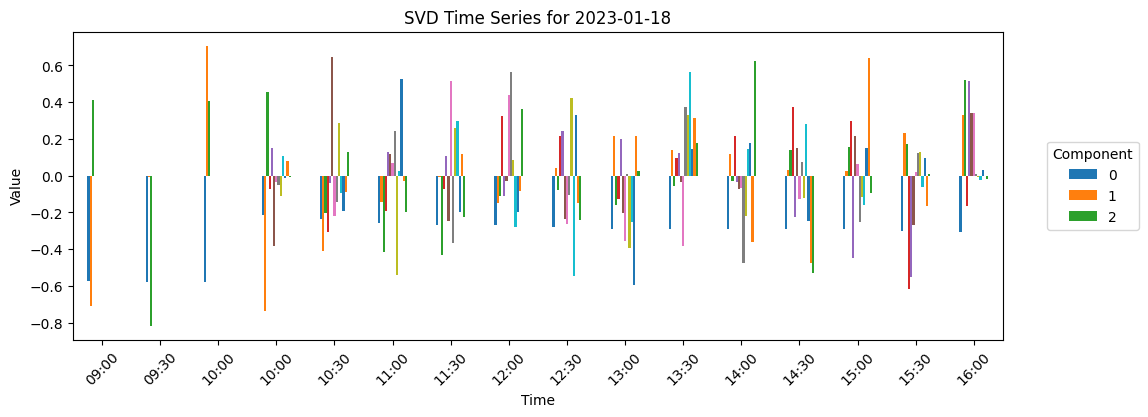

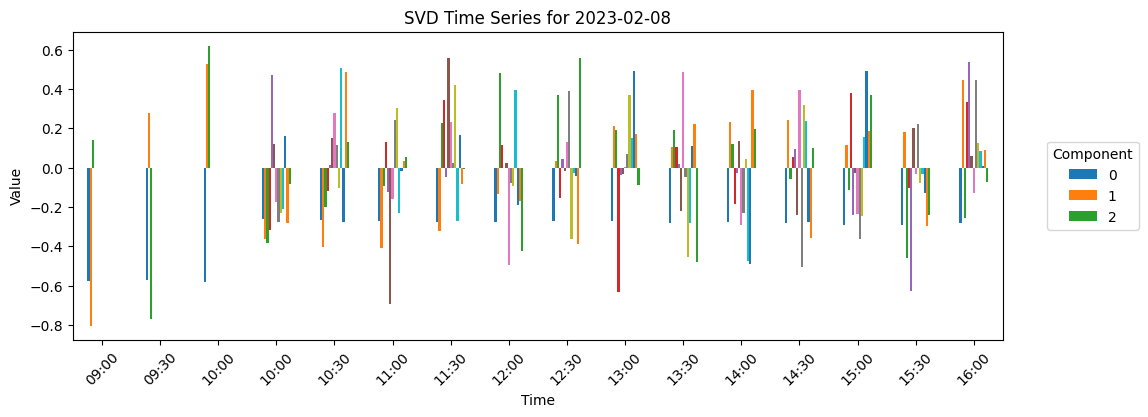

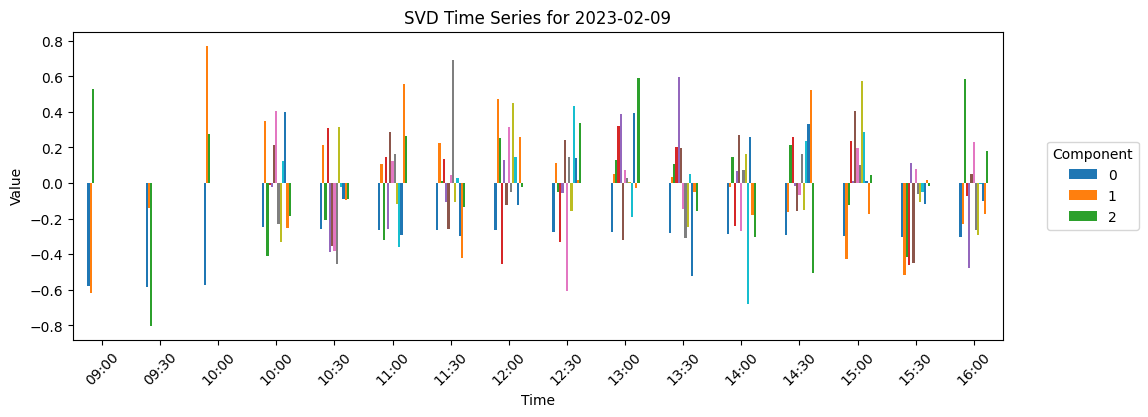

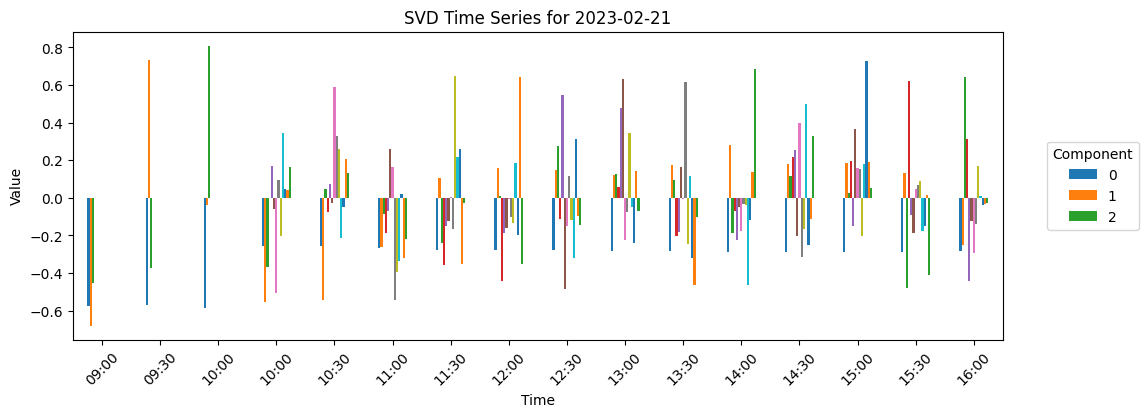

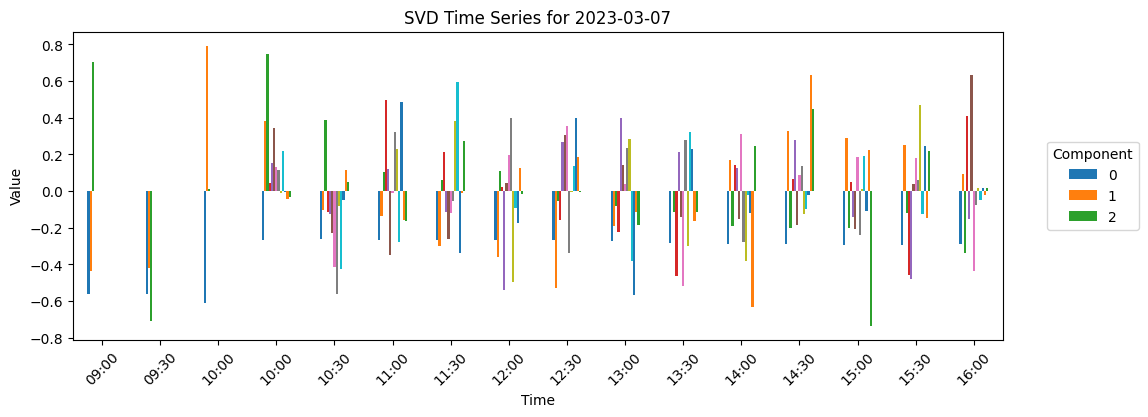

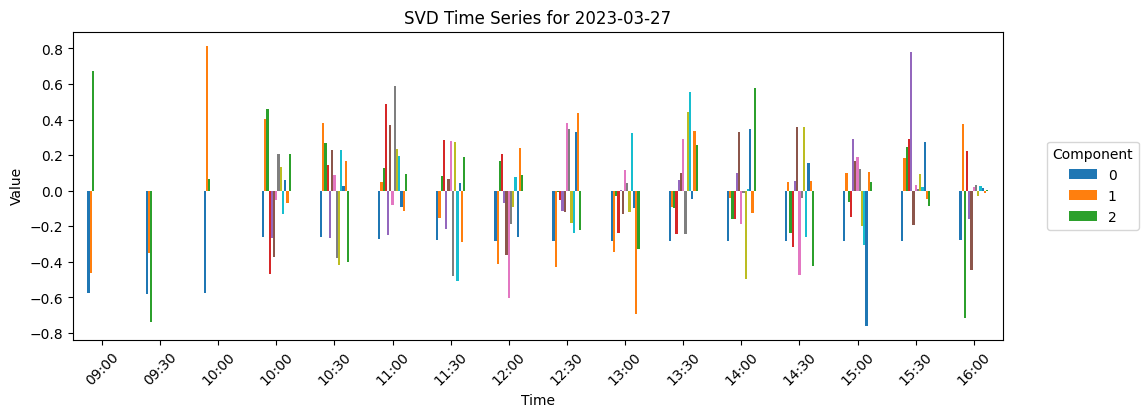

In [33]:
from scipy.linalg import svd

def clean_data(df):
    # Replace infs with NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    # Drop rows with NaNs or fill them with appropriate values
    df = df.dropna()  # Or  df = df.fillna(some_value)
    return df

# Modify the perform_svd function to clean the data before performing SVD
# def perform_svd(window_data):
#     cleaned_data = clean_data(window_data)
#     U, s, Vt = svd(cleaned_data)
#     return pd.DataFrame(U, index= cleaned_data.index)


# Function to perform SVD on a given data window
def perform_svd(window_data):
    cleaned_data = clean_data(window_data)
    if cleaned_data.shape[0] < 2 or cleaned_data.shape[1] < 2:
        return None
    U, s, Vt = svd(cleaned_data)
    return pd.DataFrame(U, index=cleaned_data.index)

# DataFrame 
# nqDown

# Resample the DataFrame into 30-minute intervals and group by day
resampled_df = nqDown.resample('30T').mean()
grouped_df = resampled_df.groupby(resampled_df.index.date)


# Iterate over the groups
for day, group in grouped_df:
    # Filter the data between 9 am and 10 am, and 10 am and 4 pm
    hour_9_to_10 = group.between_time('09:00', '10:00')
    rest_of_hours = group.between_time('10:00', '16:00')

    # Perform SVD on both parts
    svd_9_to_10 = perform_svd(hour_9_to_10)
    svd_rest = perform_svd(rest_of_hours)

    # Check if the SVD results are valid
    valid_svd = svd_9_to_10 is not None and svd_rest is not None

    if valid_svd:
        # Combine the SVD results
        combined_svd = pd.concat([svd_9_to_10, svd_rest], axis= 0)

        # Plot the combined SVD result as a bar plot
        combined_svd.plot(kind='bar', figsize=(12, 4))
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.title(f"SVD Time Series for {day}")
        plt.legend(svd_9_to_10.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
        plt.xticks(range(len(combined_svd.index)), [t.strftime('%H:%M') for t in combined_svd.index.time], rotation= 45)
        plt.show()
    else:
        continue
        # print(f"Skipping {day} due to insufficient data")


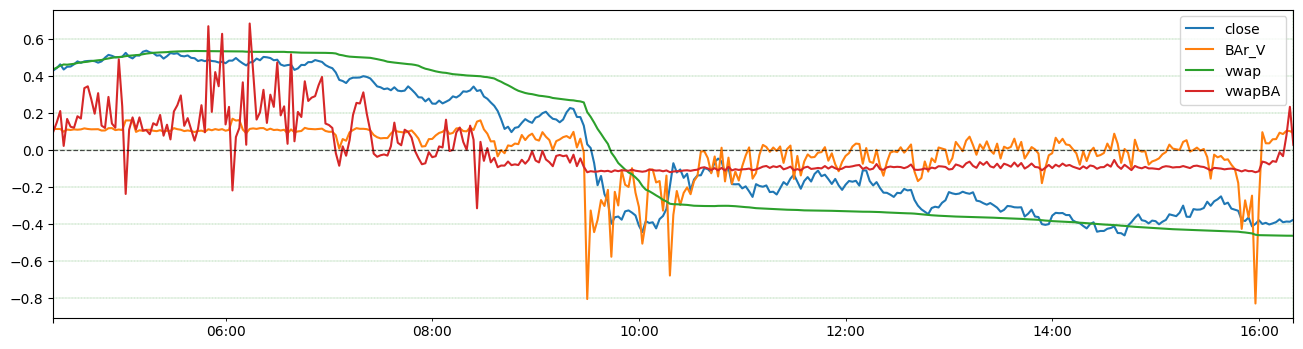

In [35]:
#  22-12-27 chwck anomaly from SVD 
nq_centered['2022-12-27 04:20:00':'2022-12-27 16:20:00'].plot(y=['close','BAr_V','vwap', 'vwapBA'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

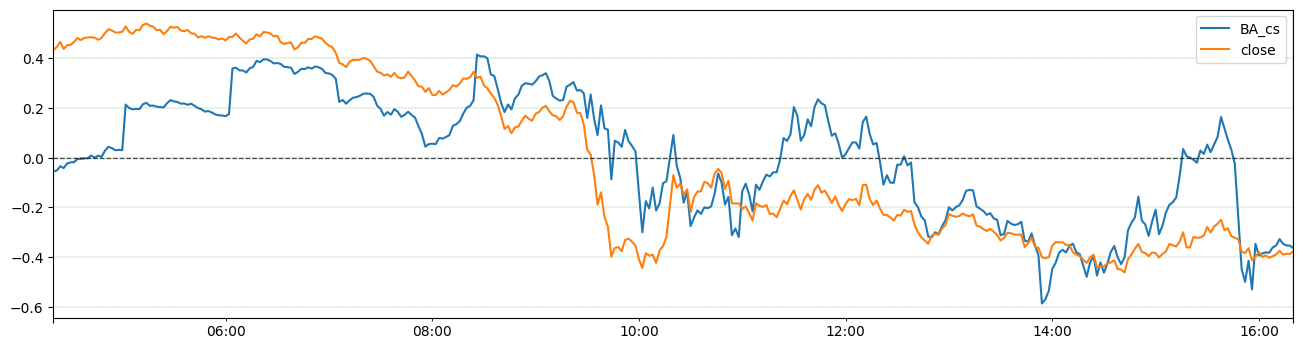

In [37]:
#  22-12-27 chwck anomaly from SVD 
nq_centered['2022-12-27 04:20:00':'2022-12-27 16:20:00'].plot(y=[ 'BA_cs', 'close'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

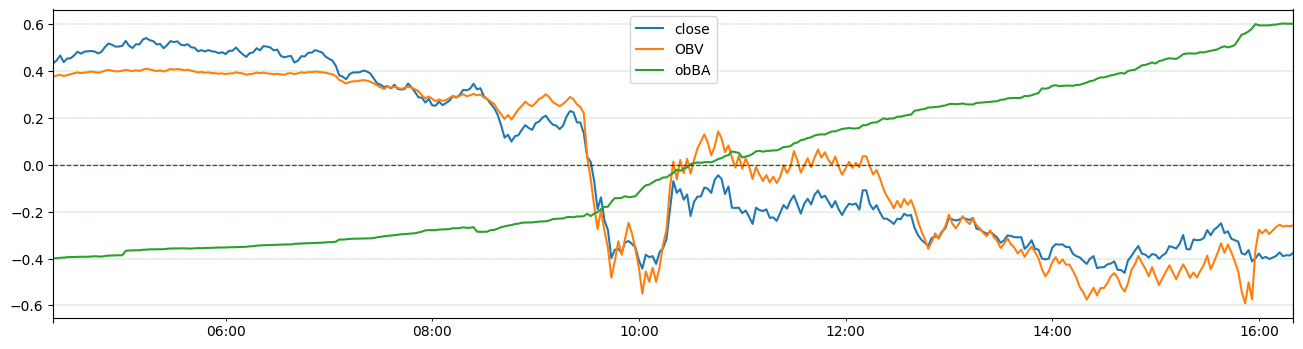

In [38]:
nq_centered['2022-12-27 04:20:00':'2022-12-27 16:20:00'].plot(y=['close','OBV', 'obBA'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

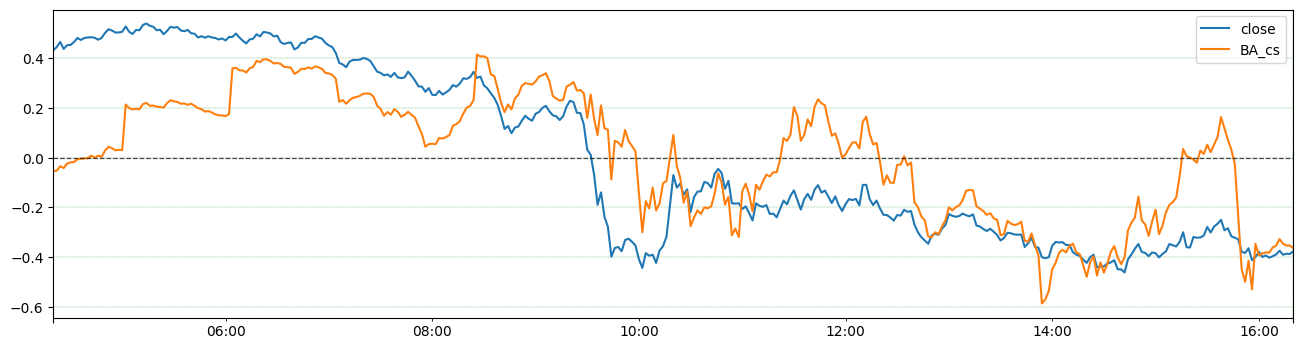

In [42]:

nq_centered['2022-12-27 04:20:00':'2022-12-27 16:20:00'].plot(y=['close','BA_cs'],figsize=(16,4))
plt.axhline(y= 0, linewidth= 0.9, linestyle = '--', color='black', alpha=0.7)  
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2) 
plt.show()

In [47]:
# del nq_centered['type']
# del nq_centered['typeD']
nq_centered.head
nq_centered.shape   # (8052, 23)
nq_centered.columns

Index(['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
       'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
       'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
      dtype='object')

In [48]:
nq_centered.shape

(8052, 23)

In [49]:
# (['Vol', 'BidAsk', 'open', 'high', 'low', 'close', 'vari', 'volat',
#        'taly', 'diff', 'pct_chng', 'fut_10', 'fut_5', 'volatility', 'BA_2m',
#        'BA_5m', 'BA_10m', 'BA_cs', 'BAr_V', 'vwap', 'vwapBA', 'OBV', 'obBA'],
 
 # Save DataFrame to a pickle file
pickle_file = "NQ_D.pkl"
nq_centered.to_pickle(pickle_file)

# pickNQ = "NQ_D.pkl"
# loaded_df = pd.read_pickle(pickNQ)
# loaded_df.head()
# (type(loaded_df.index))

- Interesting: When Price crosses Down more aggresively BA_cs, deeper directional Down moves may be expected (without great counter retracements)! (other Down charts indicate just slight close proximity of Price to BA_cs)

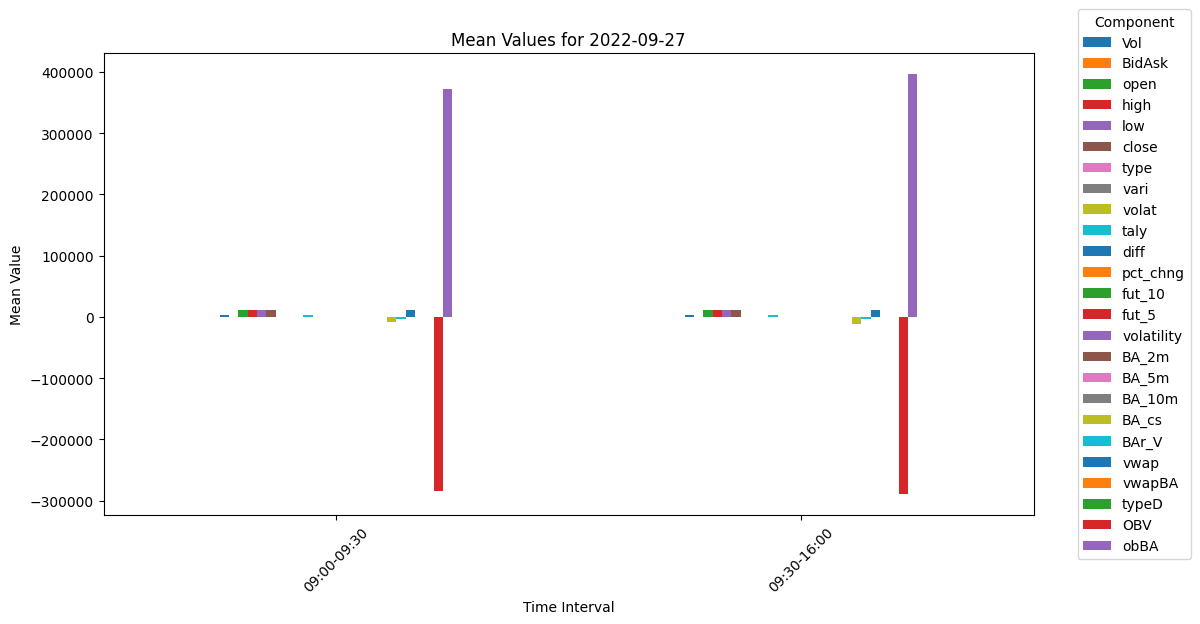

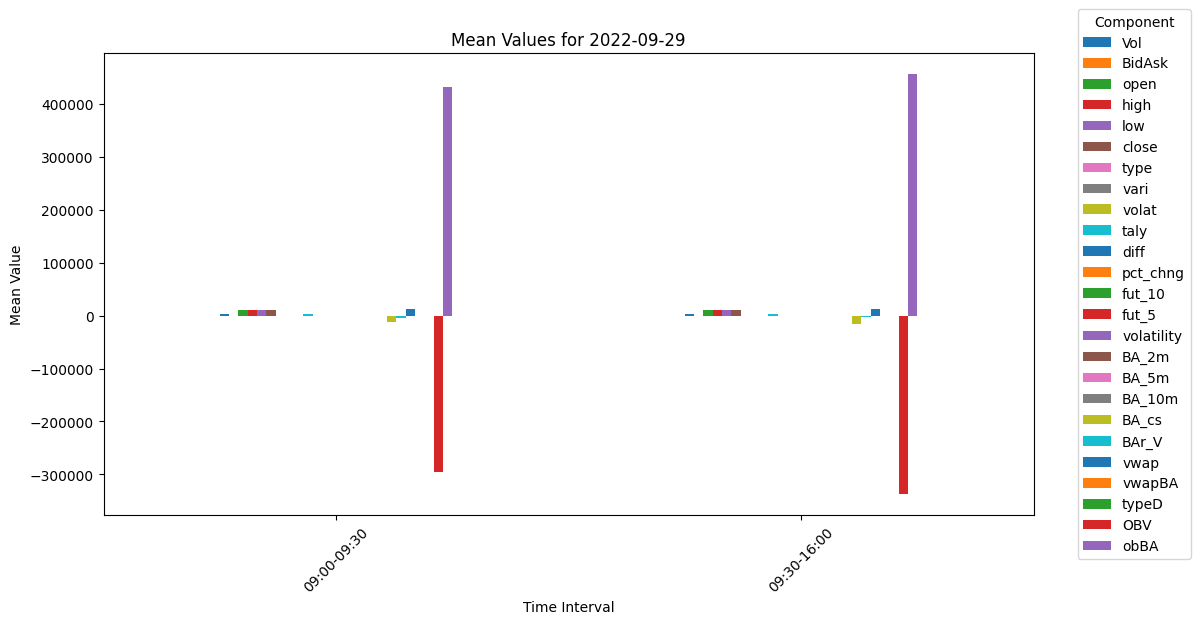

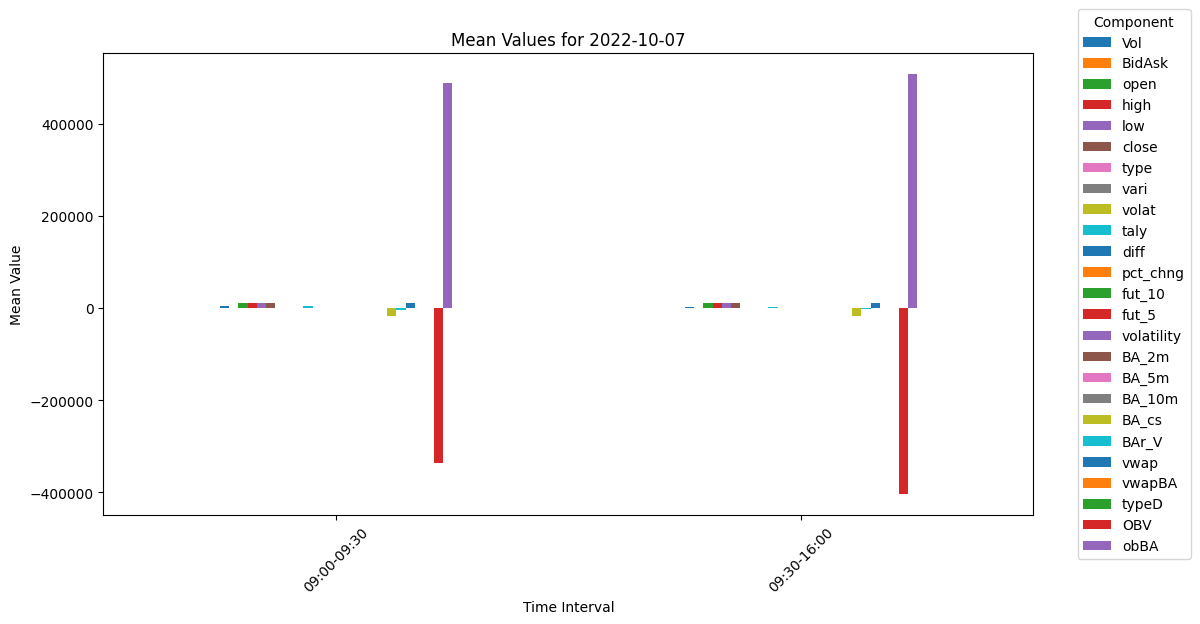

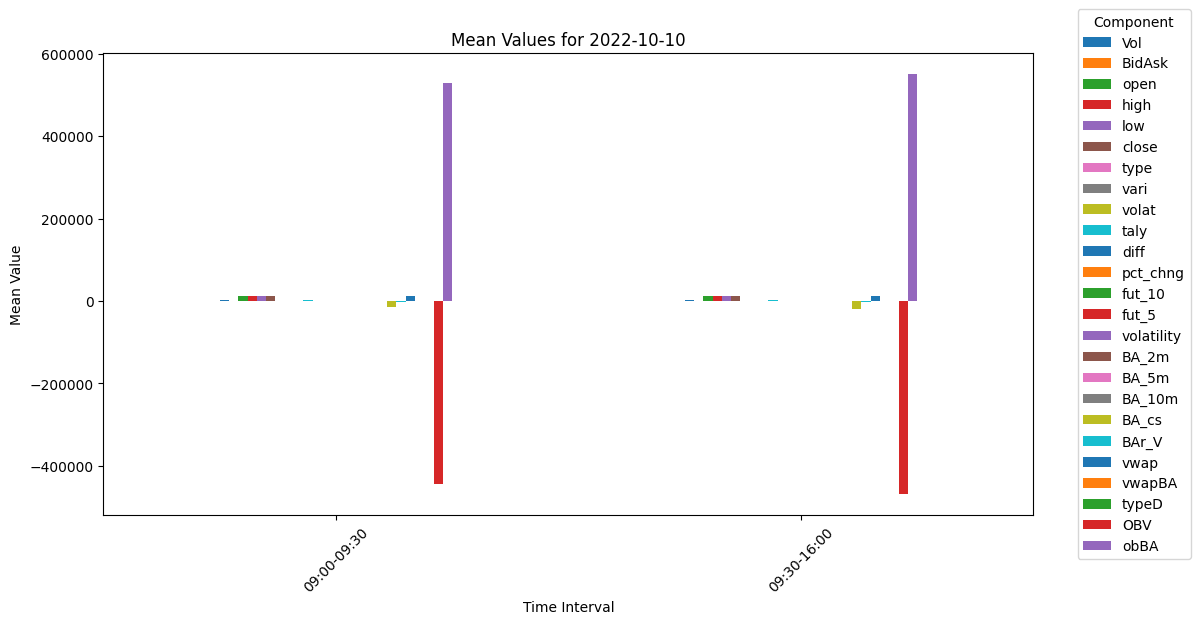

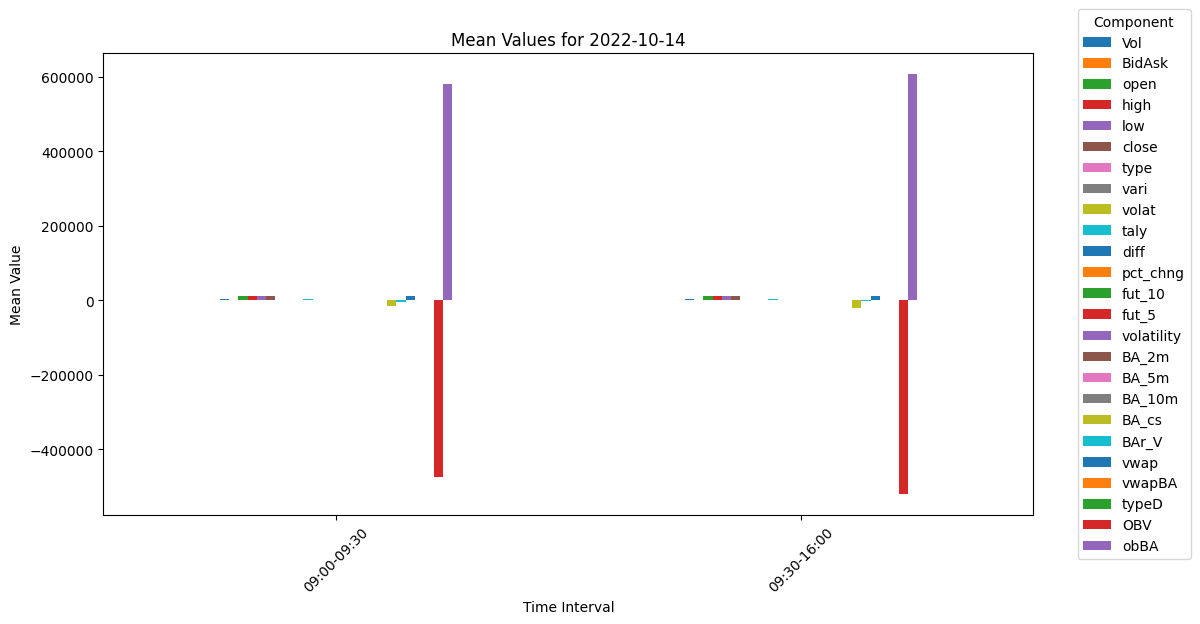

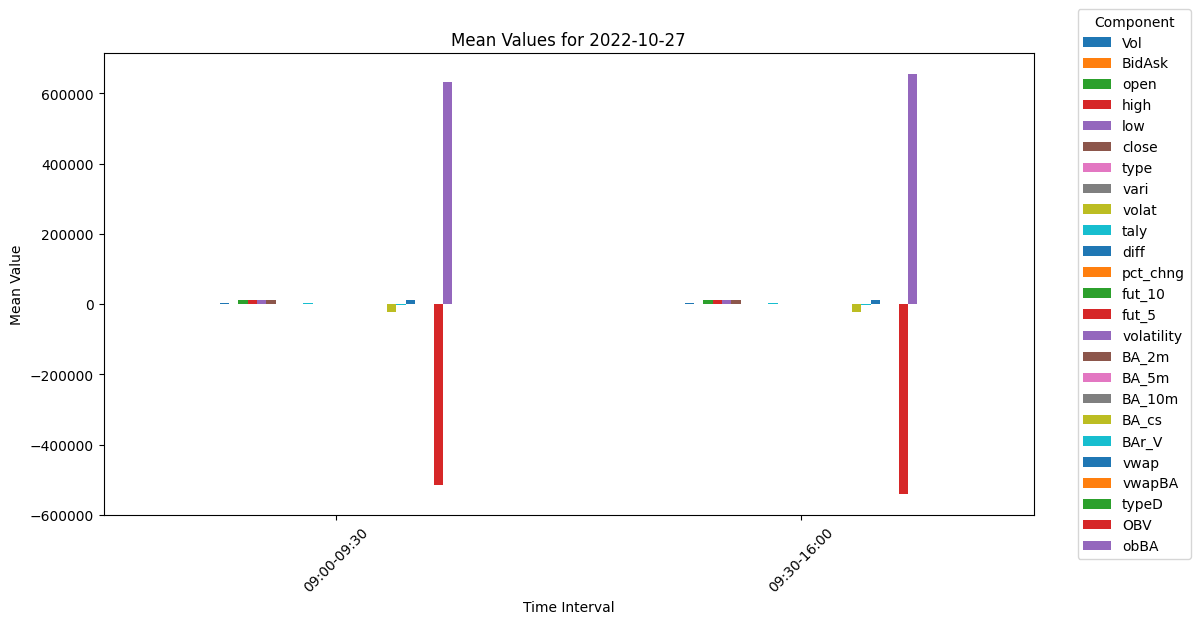

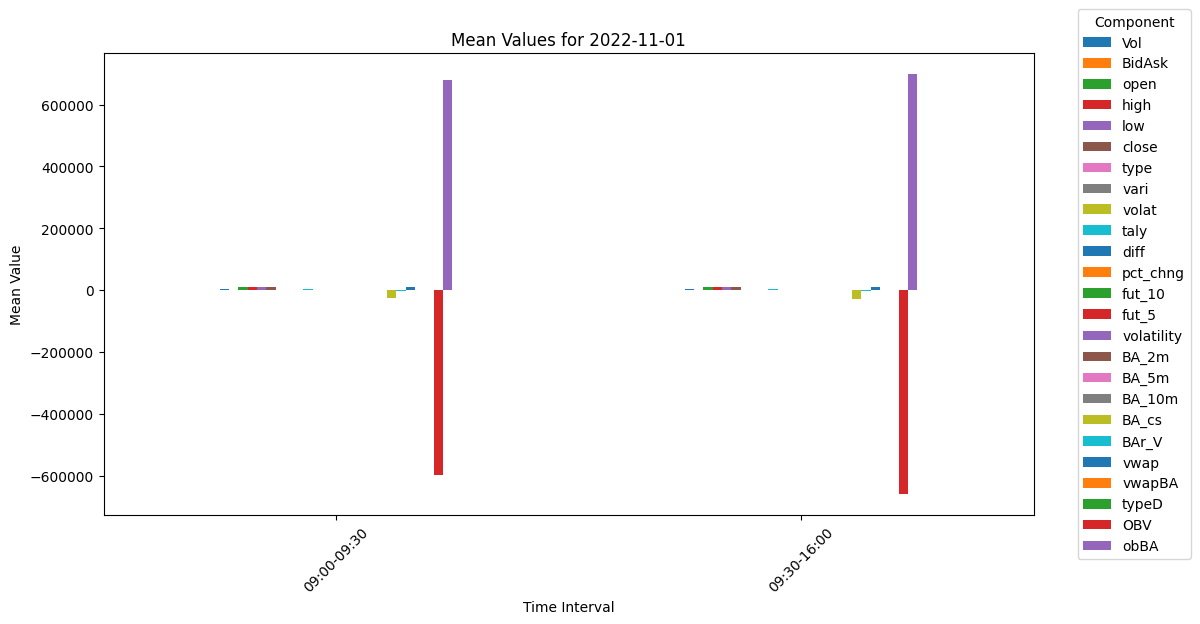

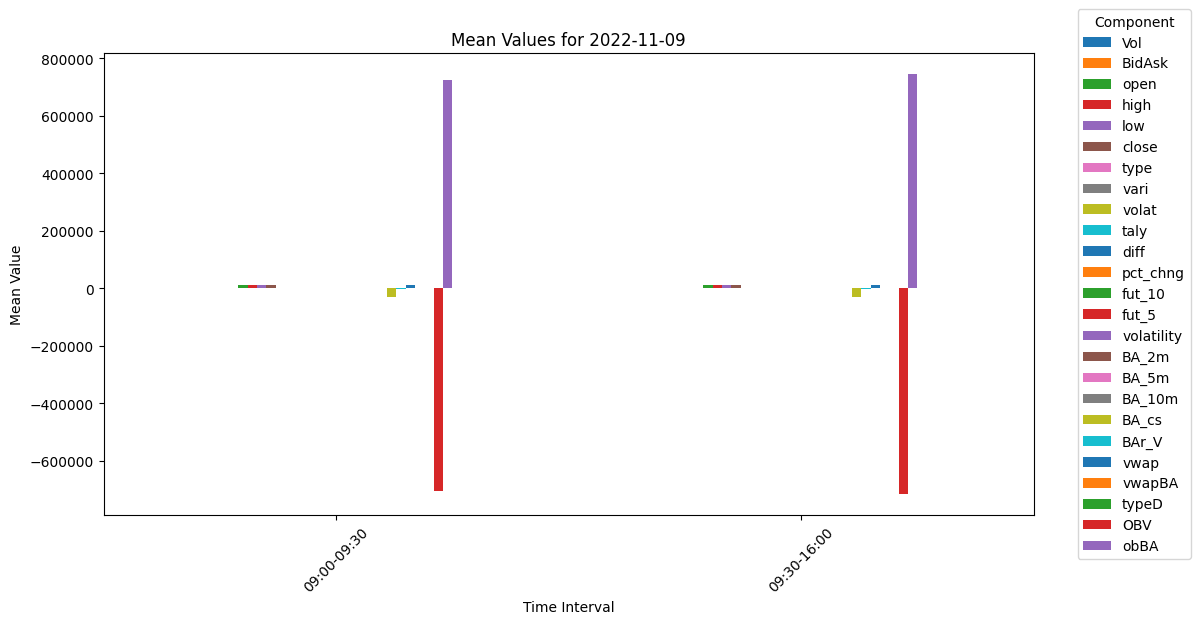

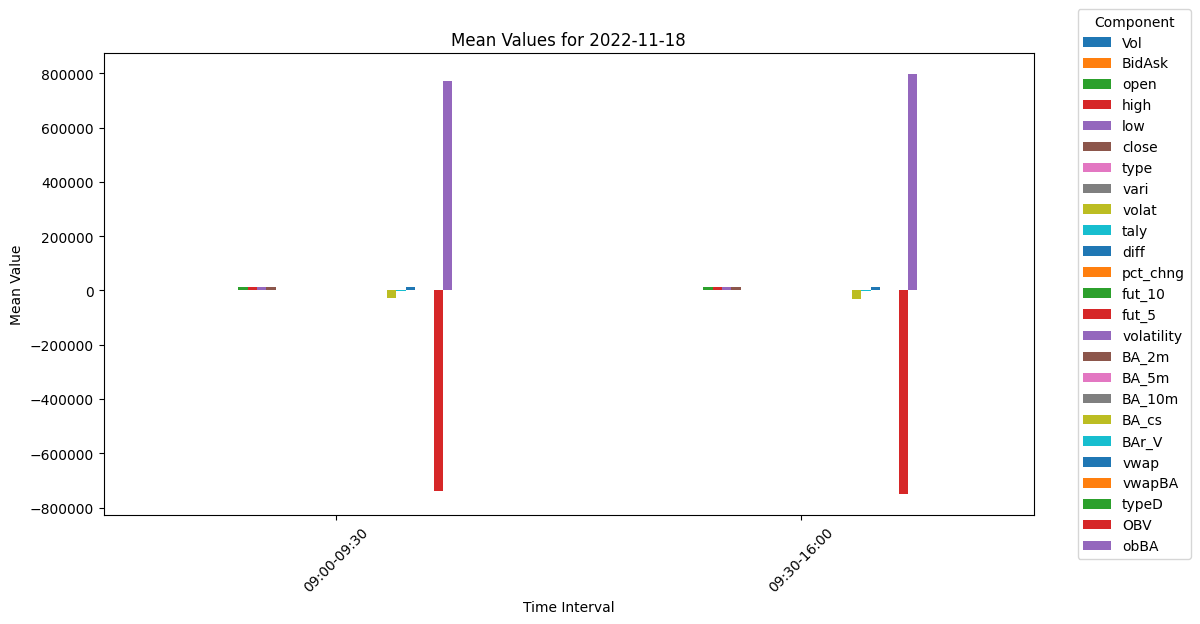

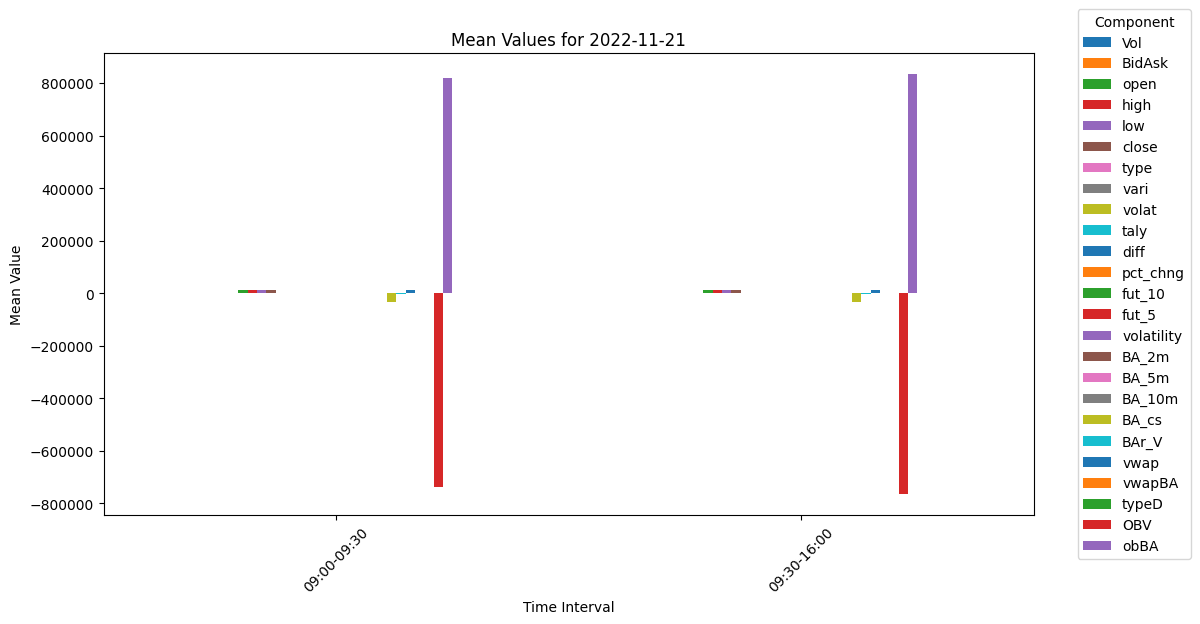

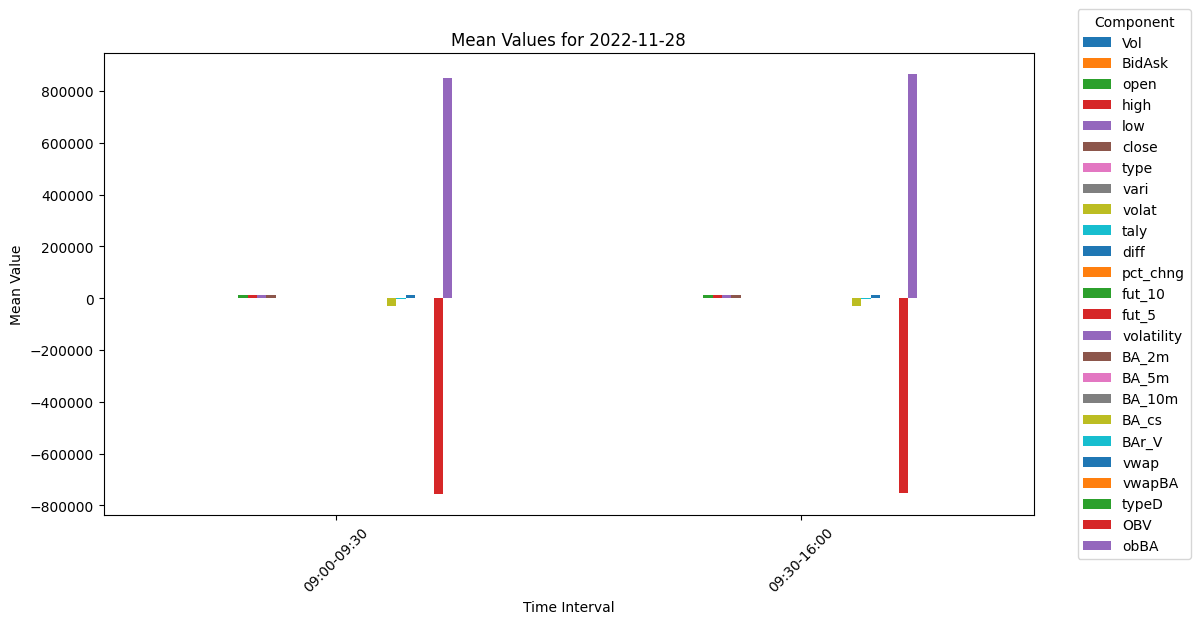

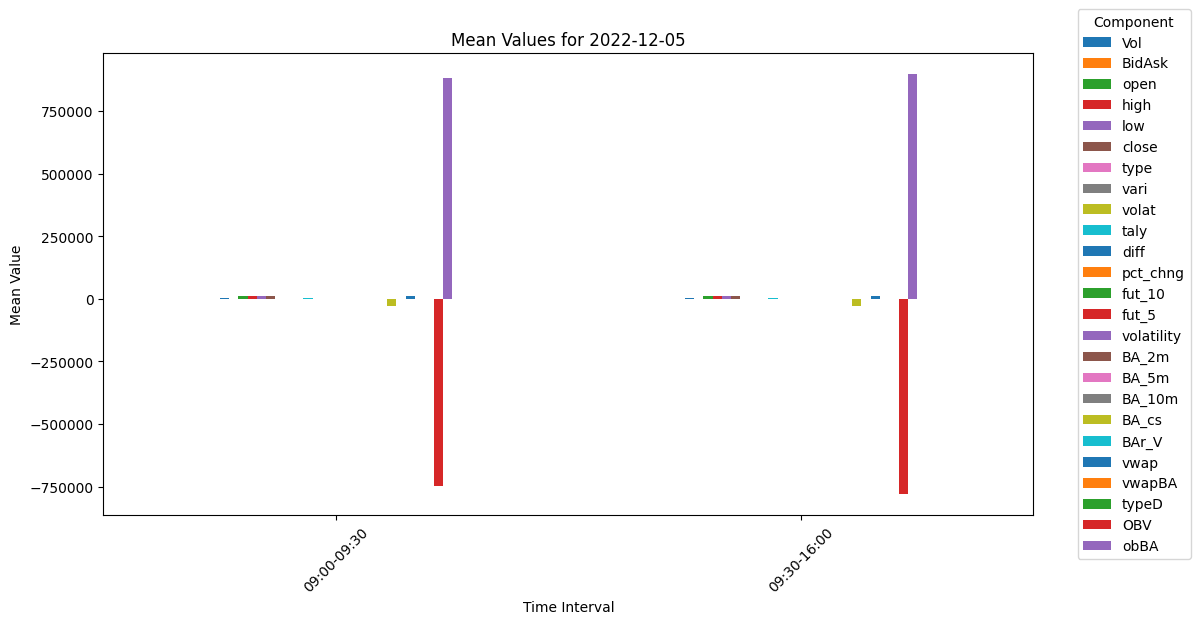

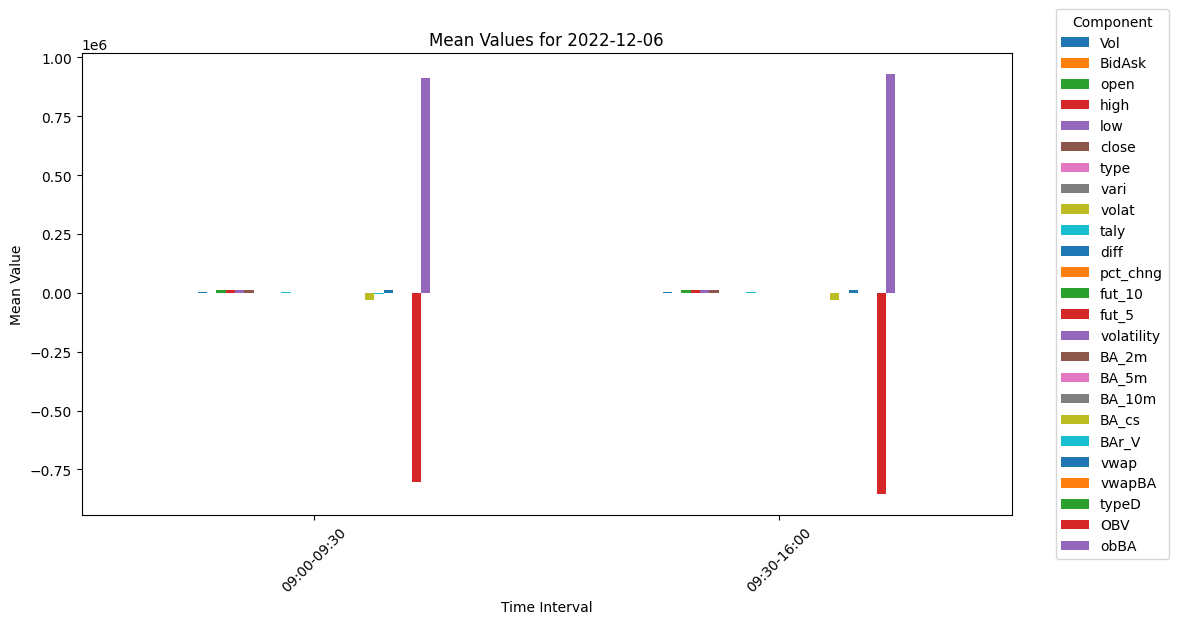

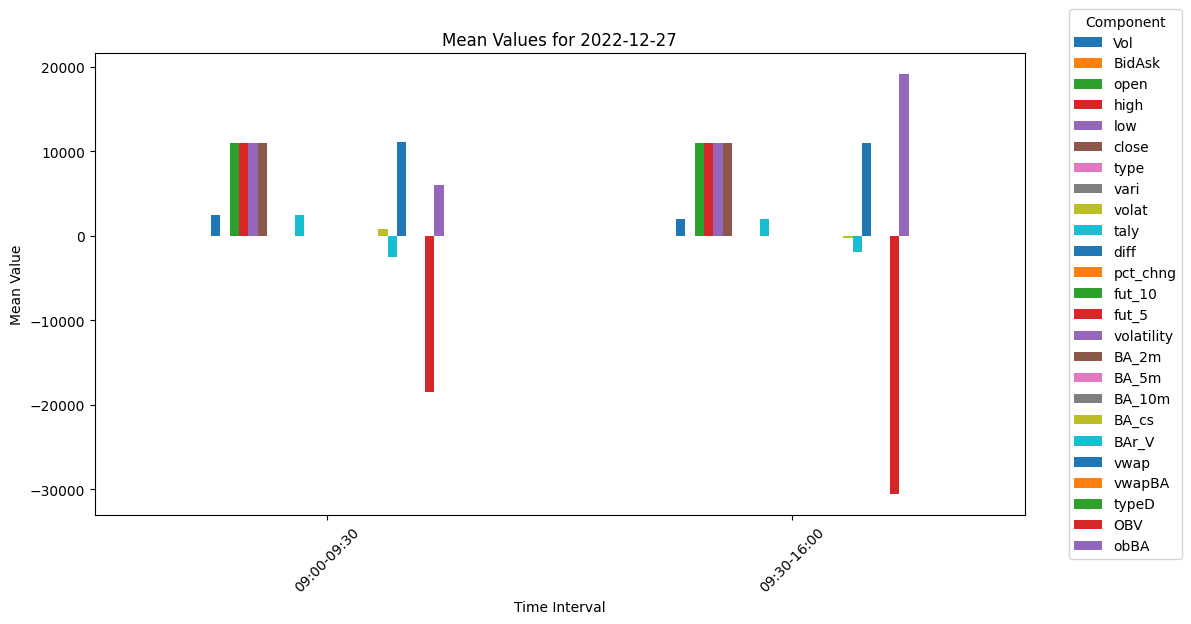

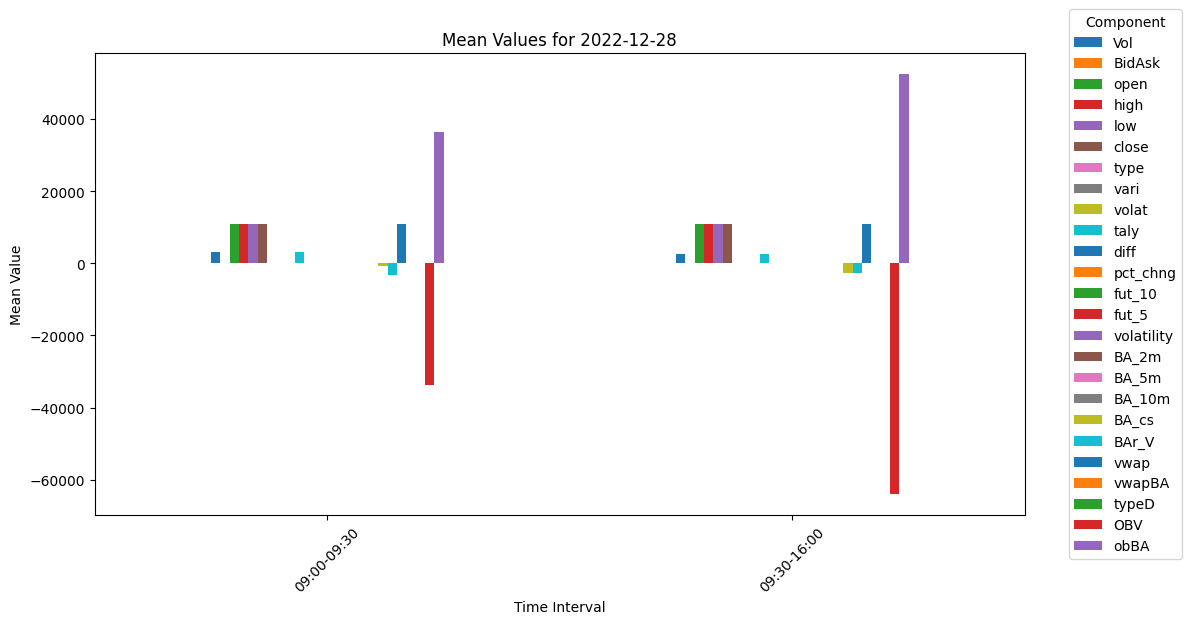

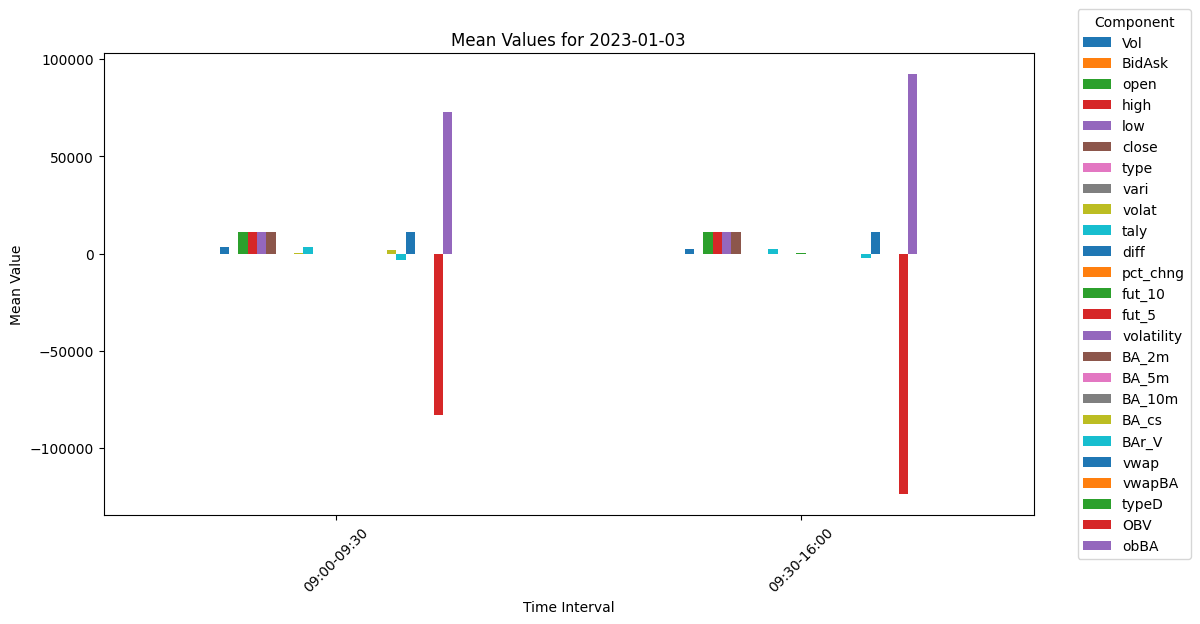

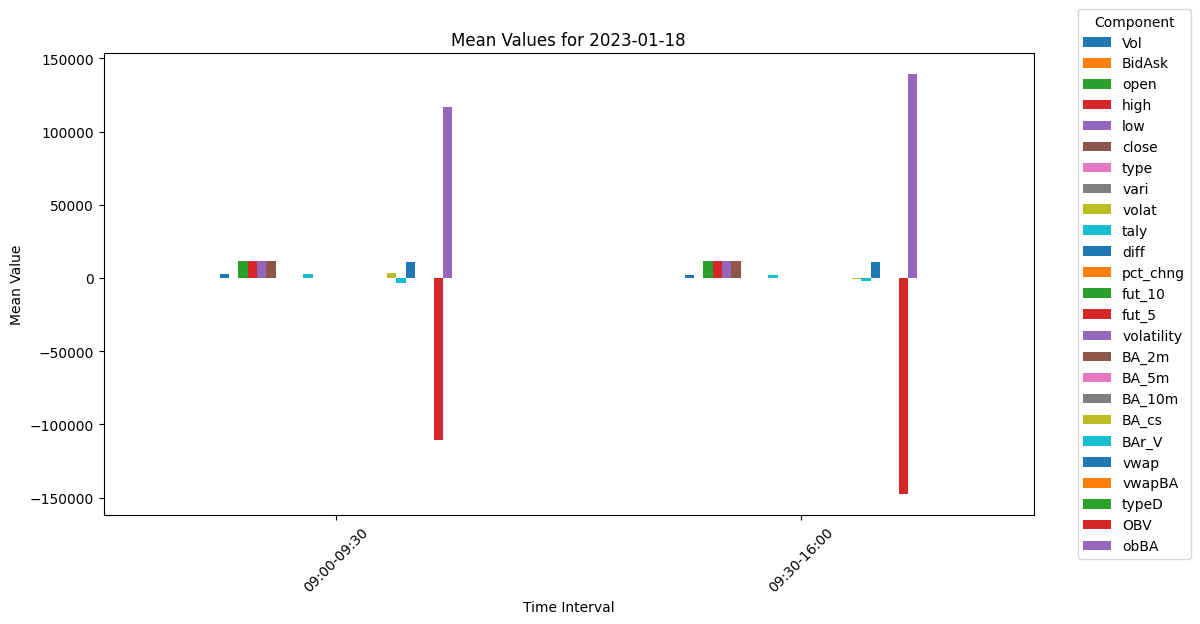

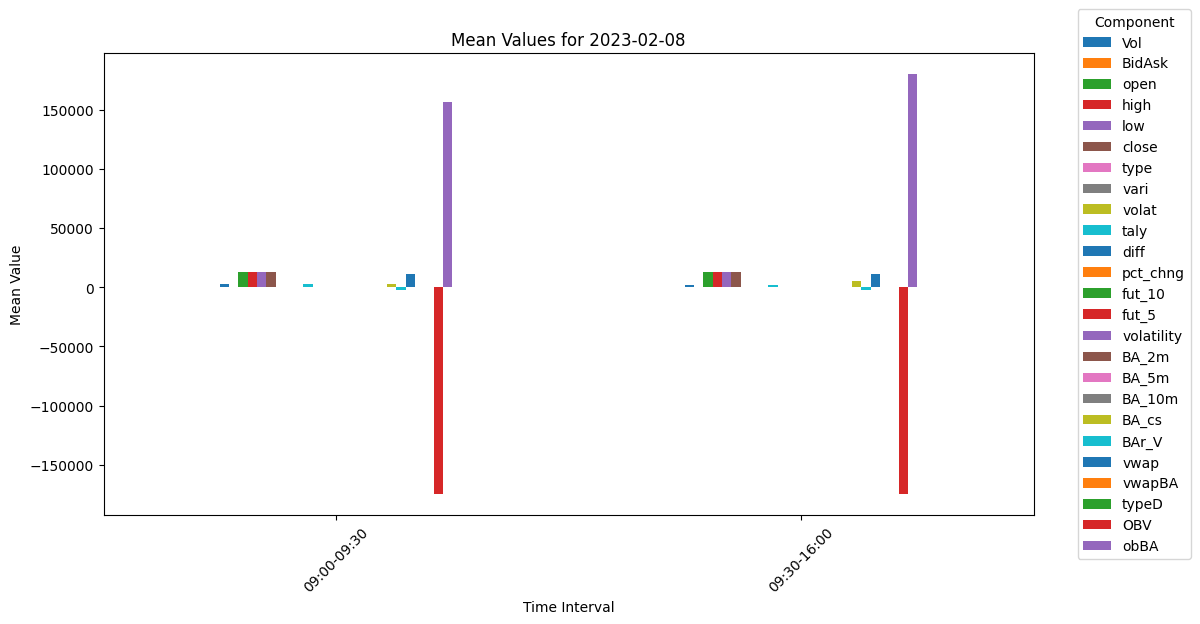

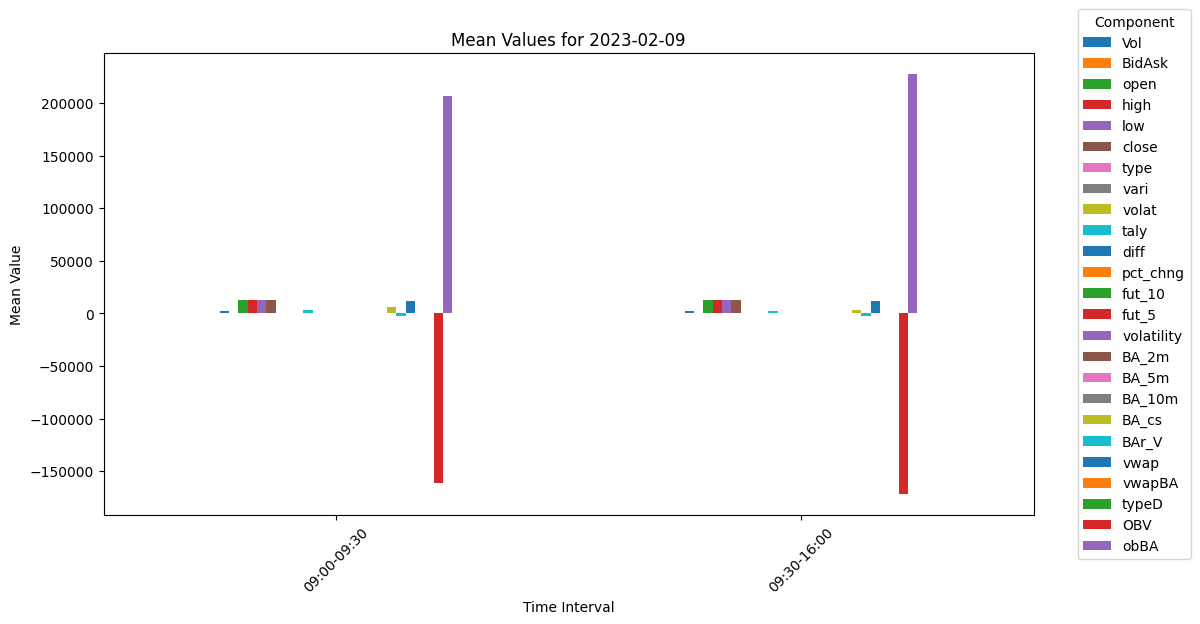

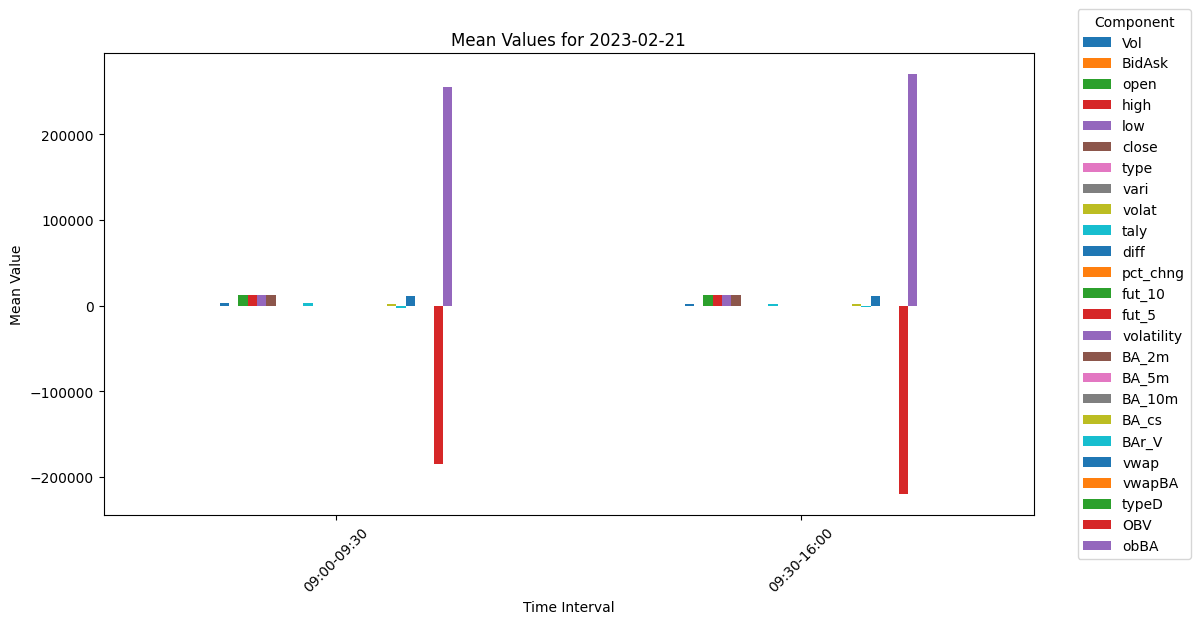

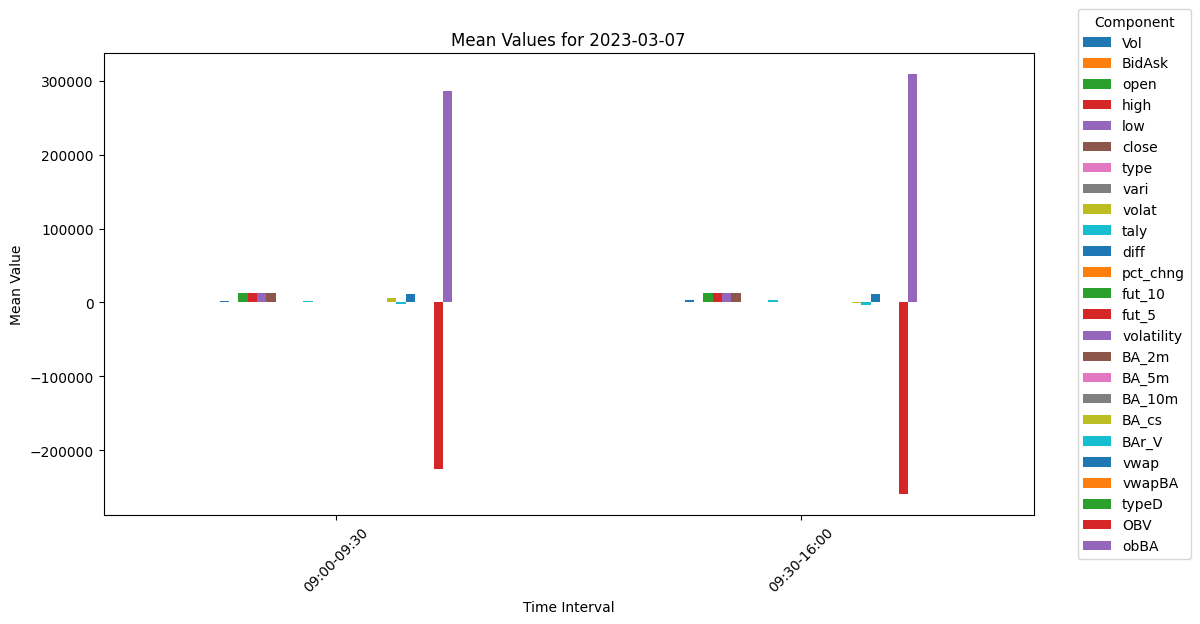

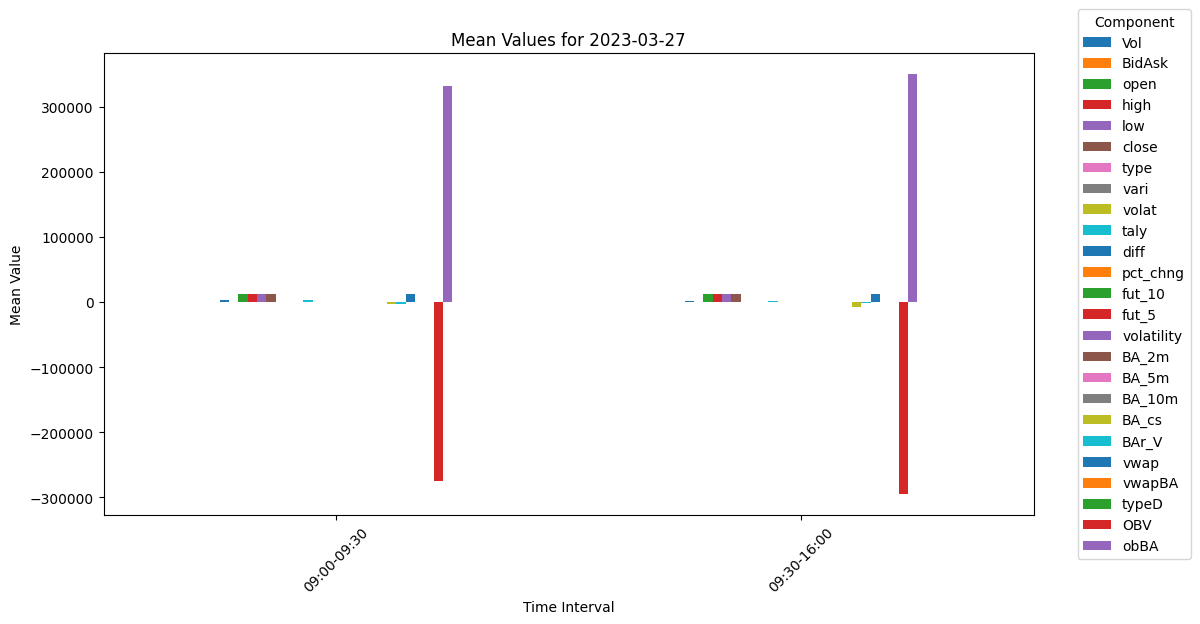

In [34]:

# nq_centered

# Resample the DataFrame into 30-minute intervals and group by day
resampled_df = nqDown.resample('30T').mean()
grouped_df = resampled_df.groupby(resampled_df.index.date)

# Iterate over the groups
for day, group in grouped_df:
    # Filter the data between 9 am and 9:30 am, and 9:30 am and 4 pm
    interval_9_to_930 = group.between_time('09:00', '09:30').dropna()
    rest_of_day = group.between_time('09:30', '16:00').dropna()

    # Check if both intervals have data
    if interval_9_to_930.empty or rest_of_day.empty:
        # print(f"Skipping {day} due to insufficient data")
        continue

    # Calculate the means for both parts
    mean_9_to_930 = interval_9_to_930.mean()
    mean_rest_of_day = rest_of_day.mean()

    # Combine the means into a new DataFrame
    combined_means = pd.concat([mean_9_to_930, mean_rest_of_day], axis=1).T
    combined_means.index = ['09:00-09:30', '09:30-16:00']

    # Plot the combined means as a bar plot
    combined_means.plot(kind='bar', figsize=(12, 6))
    plt.xlabel("Time Interval")
    plt.ylabel("Mean Value")
    plt.title(f"Mean Values for {day}")
    plt.legend(combined_means.columns, title="Component", bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.xticks(range(len(combined_means.index)), combined_means.index, rotation=45)
    plt.show()
